In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

520

# Global path

In [51]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
cmap_home = data_home + 'CMAP2020_Cancer/'
shift_home = poseidon_home + 'shift_ability/'
panel_home = poseidon_home + 'panels/Figure4/'
cbio_home = poseidon_home + 'CBIO/'

In [4]:
# list of EC genes with both pharmacological and genetic inhibition available
bitarget_gene_info = pd.read_csv(poseidon_home + 'EC_signatures/sh_cp_available_NREC_REC_gene_info.csv',
                                 header=0, index_col=0, sep=',')

In [5]:
shRNA_cancer = ['BRCA', 'CRC', 'LIHC', 'LUNG', 'PRAD', 'SKCM']
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']


# read the shRNA enrichment results
shRNA_result = {}
for ct in shRNA_cancer:
    shRNA_result[ct] = pd.read_csv(shift_home + ct + '_trt_sh.csv',
                                   sep=',', index_col=0)
    shRNA_result[ct]['cancer_type'] = ct
    print(ct, shRNA_result[ct].shape)
    
# read the compound enrichment results
compound_result = {}
for ct in compound_cancer:
    compound_result[ct] = pd.read_csv(shift_home + ct + '_trt_cp.csv',
                                   sep=',', index_col=0)
    compound_result[ct]['cancer_type'] = ct
    print(ct, compound_result[ct].shape)

BRCA (2060, 7)
CRC (1317, 7)
LIHC (1437, 7)
LUNG (2828, 7)
PRAD (3923, 7)
SKCM (2384, 7)
BLCA (5, 7)
BRCA (9573, 7)
CESC (2906, 7)
CRC (4516, 7)
LIHC (2361, 7)
LUNG (6901, 7)
OV (53, 7)
PAAD (1906, 7)
PRAD (8107, 7)
SKCM (4917, 7)
STAD (38, 7)
UCEC (38, 7)


In [6]:
# merge the results into the matrix
merged_shRNA = pd.concat([shRNA_result[d] for d in shRNA_result.keys()], axis=0)
merged_compound = pd.concat([compound_result[d] for d in compound_result.keys()], axis=0)

In [7]:
merged_shRNA 

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type
KDA007_MCF7_144H:TRCN0000296008:-666,-0.355377,0.543419,AKAP13,NaN,NaN,0.898797,BRCA
KDA008_MCF7_96H:TRCN0000107234:-666,-0.385176,0.500810,CARD9,NaN,NaN,0.885986,BRCA
KDA008_MCF7_96H:P07,-0.385176,0.500810,CARD9,NaN,NaN,0.885986,BRCA
KDA009_MCF7_144H:TRCN0000045929:-666,-0.339230,0.534220,FPGS,NaN,NaN,0.873451,BRCA
KDA007_MCF7_144H:TRCN0000122875:-666,-0.394790,0.473771,AMIGO3,NaN,NaN,0.868561,BRCA
...,...,...,...,...,...,...,...
KDB010_A375_96H:TRCN0000150124:-666,0.318553,-0.375741,MVP,NaN,NaN,-0.694294,SKCM
KDD009_A375_96H:TRCN0000039942:-666,0.283743,-0.413925,PRKAR1A,NaN,NaN,-0.697668,SKCM
KDD001_A375_96H:TRCN0000051864:-666,0.311558,-0.392425,DDAH1,NaN,NaN,-0.703983,SKCM
TAK003_A375_96H:TRCN0000009883:-666,0.298656,-0.435979,EP300,NaN,NaN,-0.734635,SKCM


In [8]:
merged_compound

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type
ERBB2001_VMCUB1_24H:BRD-K42805893:10,-0.440463,0.303870,AZD-9291,10.00,10 uM,0.744333,BLCA
ERBB2002_J82_24H:BRD-K66175015:10,-0.327901,0.377128,afatinib,10.00,10 uM,0.705029,BLCA
ERBB2002_5637_24H:BRD-K66175015:10,-0.313779,0.368062,afatinib,10.00,10 uM,0.681841,BLCA
ERBB2001_VMCUB1_24H:BRD-K66175015:10,-0.277081,0.347362,afatinib,10.00,10 uM,0.624442,BLCA
ERBB2002_J82_24H:BRD-K42805893:10,-0.266715,-0.307608,AZD-9291,10.00,10 uM,-0.040893,BLCA
...,...,...,...,...,...,...,...
CPC006_SNGM_6H:BRD-A79465854-001-01-3:10,-0.154705,-0.176438,auranofin,10.00,10 uM,-0.021733,UCEC
CPC006_JHUEM2_6H:BRD-K74402642-003-01-2:10,-0.185357,-0.269428,NSC-632839,10.00,10 uM,-0.084071,UCEC
CPC006_SNGM_6H:BRD-A15079084-001-02-9:10,0.187616,-0.172240,BRD-A15079084,10.00,10 uM,-0.359856,UCEC
CPC006_SNGM_6H:BRD-A28105619-001-01-3:10,0.223700,-0.251825,BRD-A28105619,10.00,10 uM,-0.475525,UCEC


In [9]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 0. Take subset based on short list

In [10]:
# shRNA
sub_shRNA = merged_shRNA[merged_shRNA['cmap_name'].isin(bitarget_gene_info.index)]
sub_shRNA.shape

(271, 7)

In [11]:
# compound target list
compound_info_sub = compound_info[compound_info['target'].isin(bitarget_gene_info.index)]

# compound pert subsets
sub_compound = merged_compound[merged_compound['cmap_name'].isin(compound_info_sub.index)]
sub_compound.shape

(5792, 7)

In [12]:
# add target info in sub_compound matrix
sub_compound['target'] = ''
for i in sub_compound.index:
    tmp_d = sub_compound.loc[i, 'cmap_name']
    sub_compound.at[i, 'target'] = compound_info_sub.loc[tmp_d, 'target']

<ipython-input-12-35367ac79791>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_compound['target'] = ''


In [13]:
sub_compound

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,target
REP.A019_MDAMB231_24H:L13,-0.445946,0.507214,dasatinib,10.000,10 uM,0.953159,BRCA,EPHA2
REP.A019_MDAMB231_24H:L16,-0.428393,0.490055,dasatinib,0.370,0.37 uM,0.918448,BRCA,EPHA2
REP.A023_MCF7_24H:O15,-0.503013,0.412289,valrubicin,1.110,1.11 uM,0.915302,BRCA,TOP2A
REP.A015_MCF7_24H:E11,-0.473579,0.441700,epirubicin,0.125,0.125 uM,0.915279,BRCA,TOP2A
REP.A019_MDAMB231_24H:L15,-0.431697,0.477136,dasatinib,1.110,1.11 uM,0.908832,BRCA,EPHA2
...,...,...,...,...,...,...,...,...
CPC006_AGS_6H:BRD-K00615600-001-06-1:25,0.162865,-0.232796,AG-14361,25.000,25 uM,-0.395661,STAD,PARP1
CPC006_AGS_6H:BRD-K71726959-001-06-7:122.55,0.207590,-0.332709,BRD-K71726959,125.000,125 uM,-0.540300,STAD,CDK5
CPC006_SNGM_6H:BRD-K64890080-001-03-9:10,-0.262499,0.338284,BI-2536,10.000,10 uM,0.600783,UCEC,PLK1
CPC006_HEC108_6H:N01,-0.318334,0.218222,idarubicin,0.080,0.08 uM,0.536556,UCEC,TOP2A


In [14]:
sub_shRNA['cmap_name'].unique().shape

(42,)

In [15]:
sub_compound['cmap_name'].unique().shape

(142,)

In [16]:
compound_info[compound_info.index.isin(sub_compound['cmap_name'].unique())]['moa'].value_counts()

CDK inhibitor                                  22
Topoisomerase inhibitor                        12
ATPase inhibitor                               10
HMGCR inhibitor                                 9
HSP inhibitor                                   8
IGF-1 inhibitor                                 6
PLK inhibitor                                   5
Aurora kinase inhibitor                         4
PARP inhibitor                                  4
Thymidylate synthase inhibitor                  3
Akt inhibitor                                   3
Dipeptidyl peptidase inhibitor                  3
Tyrosine kinase inhibitor                       3
Src inhibitor                                   2
C-Met inhibitor                                 2
APEX inhibitor                                  2
RNA synthesis inhibitor                         2
Ribonucleotide reductase inhibitor              2
Calcineurin inhibitor                           2
Casein kinase inhibitor                         2


# 1. Visualize by the strip plots

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 [Text(0, 0, 'FBP1'),
  Text(1, 0, 'RRM1'),
  Text(2, 0, 'FDPS'),
  Text(3, 0, 'CTNNB1'),
  Text(4, 0, 'TYMS'),
  Text(5, 0, 'JAK3'),
  Text(6, 0, 'PLK1'),
  Text(7, 0, 'HMGCR'),
  Text(8, 0, 'CSNK2A1'),
  Text(9, 0, 'PTK2'),
  Text(10, 0, 'PAK4'),
  Text(11, 0, 'SMAD3'),
  Text(12, 0, 'DHFR'),
  Text(13, 0, 'CDK4'),
  Text(14, 0, 'BIRC5'),
  Text(15, 0, 'ATP1A1'),
  Text(16, 0, 'CSNK1E'),
  Text(17, 0, 'MET'),
  Text(18, 0, 'HSP90AA1'),
  Text(19, 0, 'PRKDC'),
  Text(20, 0, 'IGF1R'),
  Text(21, 0, 'FKBP1A'),
  Text(22, 0, 'AURKA'),
  Text(23, 0, 'ACLY'),
  Text(24, 0, 'RPS6KA1'),
  Text(25, 0, 'HDAC2'),
  Text(26, 0, 'LCK'),
  Text(27, 0, 'PPIA'),
  Text(28, 0, 'PARP1'),
  Text(29, 0, 'PI4KB'),
  Text(30, 0, 'CDK7'),
  Text(31, 0, 'AKT3'),
  Text(32, 0, 'DPYD'),
  Text(33, 0, 'SMO'),
  Text(34,

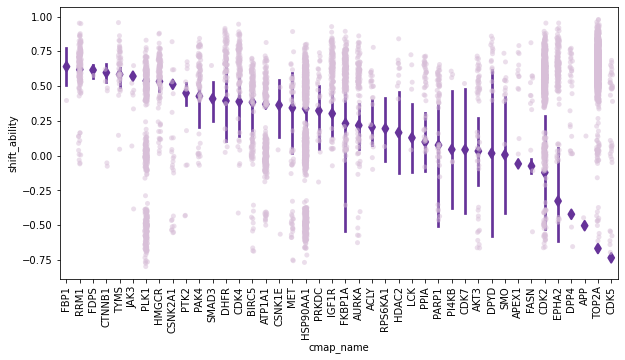

In [17]:
# sort by shRNA mean shift
target_order = sub_shRNA.groupby('cmap_name').mean().sort_values(by='shift_ability', ascending=False).index

plt.figure(figsize=(10, 5))

# compound shift ability
sns.stripplot(x='target', y='shift_ability',
              data=sub_compound, order=target_order,
              dodge=False, alpha=.5, color='thistle')

# shRNA
sns.pointplot(x='cmap_name', y='shift_ability', data=sub_shRNA,
              order=target_order, join=False, markers='d',
              color='rebeccapurple')

plt.xticks(rotation=90)

In [18]:
# add cell line information
sub_compound['cell_line'] = sig_info['cell_iname']
sub_shRNA['cell_line'] = sig_info['cell_iname']

<ipython-input-18-221cd861e7eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_compound['cell_line'] = sig_info['cell_iname']
<ipython-input-18-221cd861e7eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_shRNA['cell_line'] = sig_info['cell_iname']


In [19]:
# calculate the average shift for each drug/shRNA in each cell line
ave_shift_shRNA = df(columns=sub_shRNA['cell_line'].unique(), index=sub_shRNA['cmap_name'].unique())
ave_shift_compound = df(columns=sub_compound['cell_line'].unique(), index=sub_compound['cmap_name'].unique())

for sh in sub_shRNA['cmap_name'].unique():
    tmp_sh = sub_shRNA[sub_shRNA['cmap_name'] == sh]
    tmp_sh_ave = df(tmp_sh.groupby('cell_line').mean()['shift_ability'])
    ave_shift_shRNA.at[sh, tmp_sh_ave.index] = tmp_sh_ave['shift_ability']

    

for d in sub_compound['cmap_name'].unique():
    tmp_d = sub_compound[sub_compound['cmap_name'] == d]
    tmp_d_ave = df(tmp_d.groupby('cell_line').mean()['shift_ability'])
    ave_shift_compound.at[d, tmp_d_ave.index] = tmp_d_ave['shift_ability']
    

In [60]:
ave_shift_shRNA.to_csv(poseidon_home + 'bi_target/ave_shift_shRNA_by_cell_line.csv', sep=',')

In [61]:
ave_shift_compound.to_csv(poseidon_home + 'bi_target/ave_shift_compound_by_cell_line.csv', sep=',')

In [20]:
# merge the table: index=drug_shRNA_cell_line, columns=target, cell_line, ave_shift in both
merge_ave_shift = df(columns=['ave_shift_sh', 'ave_shift_cp', 'cell_line', 'target', 'compound_name'])
for d in ave_shift_compound.index:
    tmp_shRNA = compound_info_sub.loc[d, 'target']
    
    # get subset of average shift ability
    tmp_d_shift = df(ave_shift_compound.loc[d, :]).dropna(axis=0, how='any')
    tmp_sh_shift = df(ave_shift_shRNA.loc[tmp_shRNA, :]).dropna(axis=0, how='any')
    
    # get overlap cell lines
    tmp_op_cl = list(set(tmp_d_shift.index) & set(tmp_sh_shift.index))
    
    for cl in tmp_op_cl:
        tmp_id = d + '_' + tmp_shRNA + '_' + cl
        merge_ave_shift.at[tmp_id, 'ave_shift_sh'] = ave_shift_shRNA.loc[tmp_shRNA, cl]
        merge_ave_shift.at[tmp_id, 'ave_shift_cp'] = ave_shift_compound.loc[d, cl]
        merge_ave_shift.at[tmp_id, 'cell_line'] = cl
        merge_ave_shift.at[tmp_id, 'target'] = tmp_shRNA
        merge_ave_shift.at[tmp_id, 'compound_name'] = d
    

In [64]:
merge_ave_shift.to_csv(poseidon_home + 'bi_target/merged_ave_shift_236_cp_sh_pairs_by_cell_line.csv', sep=',')

In [21]:
merge_ave_shift

,ave_shift_sh,ave_shift_cp,cell_line,target,compound_name
dasatinib_EPHA2_A549,-0.688175,0.402755,A549,EPHA2,dasatinib
dasatinib_EPHA2_MCF7,-0.529494,0.408813,MCF7,EPHA2,dasatinib
dasatinib_EPHA2_A375,0.00535388,0.583295,A375,EPHA2,dasatinib
epirubicin_TOP2A_VCAP,-0.666852,0.639259,VCAP,TOP2A,epirubicin
mitoxantrone_TOP2A_VCAP,-0.666852,0.517769,VCAP,TOP2A,mitoxantrone
...,...,...,...,...,...
NVP-ADW742_IGF1R_PC3,0.369188,0.6738,PC3,IGF1R,NVP-ADW742
BMS-265246_CDK2_A375,-0.60407,0.179003,A375,CDK2,BMS-265246
NSC-693868_CDK5_PC3,-0.733782,0.0571397,PC3,CDK5,NSC-693868
7-hydroxystaurosporine_CDK4_A375,0.62028,0.517734,A375,CDK4,7-hydroxystaurosporine


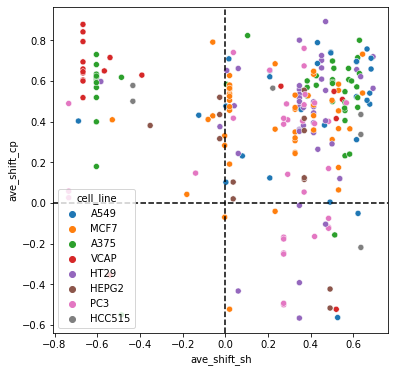

In [22]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='ave_shift_sh', y='ave_shift_cp',
                hue='cell_line', data=merge_ave_shift)
plt.axvline(x=0., ls='--', c='k')
plt.axhline(y=0., ls='--', c='k')

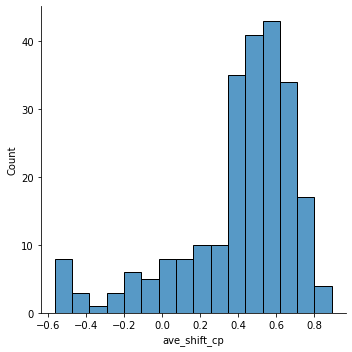

In [23]:
sns.displot(merge_ave_shift['ave_shift_cp'])

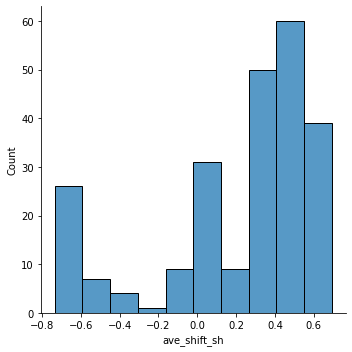

In [24]:
sns.displot(merge_ave_shift['ave_shift_sh'])

In [25]:
top_ave_shift = merge_ave_shift[merge_ave_shift['ave_shift_cp'] > 0.2]
top_ave_shift = top_ave_shift[top_ave_shift['ave_shift_sh'] > 0.2]
top_ave_shift.shape

(126, 5)

In [123]:
top_ave_shift.to_csv(poseidon_home + 'bi_target/top_ave_shift_126_cp_sh_pairs_by_cell_line.csv', sep=',')

<AxesSubplot:xlabel='ave_shift_sh', ylabel='ave_shift_cp'>

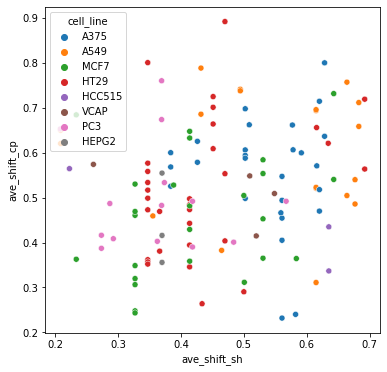

In [26]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='ave_shift_sh', y='ave_shift_cp',
                hue='cell_line', data=top_ave_shift)

<AxesSubplot:xlabel='ave_shift_sh', ylabel='ave_shift_cp'>

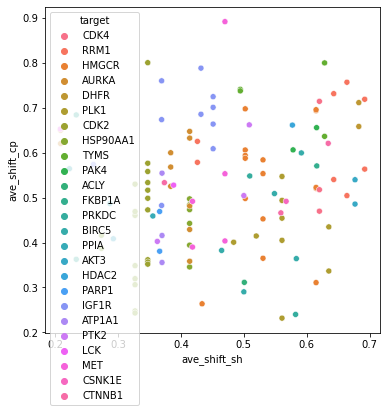

In [27]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='ave_shift_sh', y='ave_shift_cp',
                hue='target', data=top_ave_shift)

In [28]:
top_ave_shift.sort_values(by='ave_shift_cp', ascending=False)

,ave_shift_sh,ave_shift_cp,cell_line,target,compound_name
PHA-665752_MET_HT29,0.469972,0.892066,HT29,MET,PHA-665752
PHA-848125_CDK2_HT29,0.347139,0.800622,HT29,CDK2,PHA-848125
trifluridine_TYMS_A375,0.628486,0.800155,A375,TYMS,trifluridine
BMS-754807_IGF1R_A549,0.431796,0.788493,A549,IGF1R,BMS-754807
BMS-754807_IGF1R_PC3,0.369188,0.760227,PC3,IGF1R,BMS-754807
...,...,...,...,...,...
pitavastatin_HMGCR_HT29,0.433572,0.263686,HT29,HMGCR,pitavastatin
NVP-AUY922_HSP90AA1_MCF7,0.326909,0.247807,MCF7,HSP90AA1,NVP-AUY922
BIIB-021_HSP90AA1_MCF7,0.326909,0.243181,MCF7,HSP90AA1,BIIB-021
NU-7441_PRKDC_A375,0.582363,0.239989,A375,PRKDC,NU-7441


In [29]:
# visualize the top by strip plots
top_raw_shift = df(index=sig_info.index, columns=['shift_ability', 'cell_line', 'target', 'cmap_name', 'pert_type'])
for t in top_ave_shift.index:
    tmp_d = t.split('_')[0]
    tmp_s = t.split('_')[1]
    tmp_c = t.split('_')[2]
    
    tmp_d_shift = sub_compound[sub_compound['cmap_name'] == tmp_d]
    tmp_d_shift = tmp_d_shift[tmp_d_shift['cell_line'] == tmp_c]
    
    tmp_s_shift = sub_shRNA[sub_shRNA['cmap_name'] == tmp_s]
    tmp_s_shift = tmp_s_shift[tmp_s_shift['cell_line'] == tmp_c]
    
    # add to top_raw_shift
    top_raw_shift.at[tmp_d_shift.index, 'shift_ability'] = tmp_d_shift['shift_ability']
    top_raw_shift.at[tmp_d_shift.index, 'cell_line'] = tmp_c
    top_raw_shift.at[tmp_d_shift.index, 'target'] = tmp_s
    top_raw_shift.at[tmp_d_shift.index, 'cmap_name'] = tmp_d
    top_raw_shift.at[tmp_d_shift.index, 'pert_type'] = 'trt_cp'
    
    
    top_raw_shift.at[tmp_s_shift.index, 'shift_ability'] = tmp_s_shift['shift_ability']
    top_raw_shift.at[tmp_s_shift.index, 'cell_line'] = tmp_c
    top_raw_shift.at[tmp_s_shift.index, 'target'] = tmp_s
    top_raw_shift.at[tmp_s_shift.index, 'cmap_name'] = tmp_s
    top_raw_shift.at[tmp_s_shift.index, 'pert_type'] = 'trt_sh'

In [30]:
top_raw_shift = top_raw_shift.dropna(axis=0, how='any')

In [31]:
top_raw_shift['shift_ability'] = top_raw_shift['shift_ability'].astype(float)

In [32]:
top_ave_shift.sort_values(by='ave_shift_sh', ascending=False)[:30]

,ave_shift_sh,ave_shift_cp,cell_line,target,compound_name
gemcitabine_RRM1_HT29,0.692327,0.719187,HT29,RRM1,gemcitabine
trimidox_RRM1_HT29,0.692327,0.563619,HT29,RRM1,trimidox
pemetrexed_DHFR_A549,0.682985,0.658548,A549,DHFR,pemetrexed
pralatrexate_DHFR_A549,0.682985,0.711695,A549,DHFR,pralatrexate
triciribine_AKT3_A549,0.676946,0.539967,A549,AKT3,triciribine
GDC-0068_AKT3_A549,0.676946,0.485756,A549,AKT3,GDC-0068
fludarabine_RRM1_A549,0.664067,0.504581,A549,RRM1,fludarabine
gemcitabine_RRM1_A549,0.664067,0.757089,A549,RRM1,gemcitabine
gemcitabine_RRM1_MCF7,0.643077,0.731636,MCF7,RRM1,gemcitabine
fludarabine_RRM1_MCF7,0.643077,0.540381,MCF7,RRM1,fludarabine


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'DHFR'),
  Text(1, 0, 'CDK4'),
  Text(2, 0, 'RRM1'),
  Text(3, 0, 'FKBP1A'),
  Text(4, 0, 'PAK4'),
  Text(5, 0, 'TYMS'),
  Text(6, 0, 'HDAC2'),
  Text(7, 0, 'CSNK1E'),
  Text(8, 0, 'PLK1'),
  Text(9, 0, 'HMGCR'),
  Text(10, 0, 'CTNNB1'),
  Text(11, 0, 'BIRC5'),
  Text(12, 0, 'ACLY'),
  Text(13, 0, 'PTK2'),
  Text(14, 0, 'MET'),
  Text(15, 0, 'PRKDC'),
  Text(16, 0, 'ATP1A1'),
  Text(17, 0, 'AKT3'),
  Text(18, 0, 'PARP1'),
  Text(19, 0, 'IGF1R'),
  Text(20, 0, 'CDK2'),
  Text(21, 0, 'HSP90AA1'),
  Text(22, 0, 'AURKA'),
  Text(23, 0, 'PPIA'),
  Text(24, 0, 'LCK')])

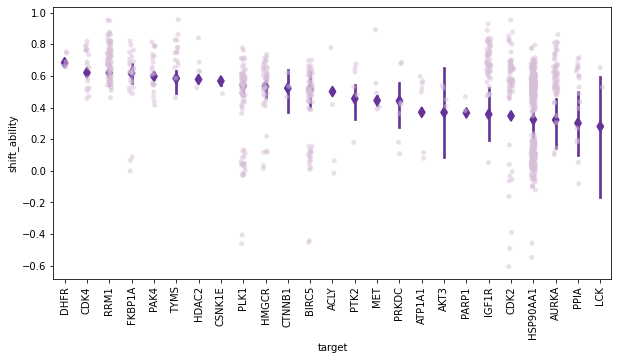

In [33]:
# sort by shRNA mean shift
target_order = top_raw_shift[top_raw_shift['pert_type'] == 'trt_sh'].groupby('target').mean().sort_values(by='shift_ability', ascending=False).index

plt.figure(figsize=(10, 5))

# compound shift ability
sns.stripplot(x='target', y='shift_ability',
              data=top_raw_shift[top_raw_shift['pert_type'] == 'trt_cp'], order=target_order,
              dodge=False, alpha=.5, color='thistle')

# shRNA
sns.pointplot(x='target', y='shift_ability', data=top_raw_shift[top_raw_shift['pert_type'] == 'trt_sh'],
              order=target_order, join=False, markers='d',
              color='rebeccapurple')

plt.xticks(rotation=90)

In [189]:
bitarget_gene_info.loc[top_ave_shift['target'].unique(), 'EC_profile']

CDK2        NR-EC
RRM1        NR-EC
BIRC5       NR-EC
PPIA        NR-EC
HMGCR       NR-EC
HSP90AA1    NR-EC
PAK4        NR-EC
FKBP1A      NR-EC
IGF1R       NR-EC
AURKA       NR-EC
CDK4        NR-EC
PLK1        NR-EC
DHFR        NR-EC
TYMS        NR-EC
ACLY        NR-EC
PRKDC       NR-EC
AKT3        NR-EC
HDAC2       NR-EC
PARP1       NR-EC
ATP1A1      NR-EC
PTK2        NR-EC
LCK          R-EC
MET         NR-EC
CSNK1E      NR-EC
CTNNB1      NR-EC
Name: EC_profile, dtype: object

# 2. Add CXCL10 correlation

In [34]:
icd_corr = pd.read_csv(poseidon_home + 'ICD/ICD_shift/corr_ICD_shift_spearmanr.csv',
                       header=0, index_col=0, sep=',')

In [35]:
icd_corr.sort_values(by='CXCL10', ascending=False)[:20]

,ANXA1,CALR,CXCL10,HMGB1,IL1B,IL17B
HS578T_BMS-387032,0.100000,0.900000,1.000000,-0.700000,0.300000,-0.600000
A375_cabazitaxel,0.714286,0.542857,0.942857,0.085714,0.942857,-0.771429
HT29_NVP-BEZ235,-0.233333,0.166667,0.900000,-0.416667,0.700000,-0.166667
A549_floxuridine,-0.900000,0.300000,0.900000,-0.900000,-0.400000,0.200000
A375_AT-7519,0.200000,0.900000,0.900000,0.300000,-0.200000,-0.600000
A375_apicidin,-0.900000,-0.700000,0.900000,-0.900000,0.700000,0.200000
YAPC_cobimetinib,0.100000,0.200000,0.900000,-0.400000,-0.700000,0.400000
PC3_BRD-K61717269,0.200000,0.200000,0.900000,-0.200000,0.000000,-0.300000
A375_pyrimethamine,-0.500000,0.200000,0.900000,-0.600000,0.500000,0.200000
HEPG2_gemcitabine,0.900000,0.600000,0.900000,0.300000,-0.300000,-0.600000


In [36]:
for t in top_ave_shift.index:
    tmp_t = t.split('_')[2] + '_' + t.split('_')[0]
    if tmp_t in icd_corr.index:
        top_ave_shift.at[t, 'CXCL10_shift_corr'] = icd_corr.loc[tmp_t, 'CXCL10']

In [37]:
top_ave_shift = top_ave_shift.sort_values(by='CXCL10_shift_corr', ascending=False)

In [38]:
top_ave_shift_cxcl10 = top_ave_shift.dropna(axis=0, how='any')
top_ave_shift_cxcl10.shape

(30, 6)

In [135]:
top_ave_shift_cxcl10.to_csv(poseidon_home + 'bi_target/top_ave_shift_30_cp_sh_pairs_with_CXCL10_corr.csv', sep=',')

In [39]:
top_ave_shift_cxcl10

,ave_shift_sh,ave_shift_cp,cell_line,target,compound_name,CXCL10_shift_corr
BMS-387032_CDK2_HT29,0.347139,0.558291,HT29,CDK2,BMS-387032,0.828571
gemcitabine_RRM1_A375,0.426152,0.625392,A375,RRM1,gemcitabine,0.729412
YM-155_BIRC5_MCF7,0.58354,0.364275,MCF7,BIRC5,YM-155,0.714286
cyclosporin-a_PPIA_A549,0.355237,0.459206,A549,PPIA,cyclosporin-a,0.714286
pitavastatin_HMGCR_A375,0.502242,0.498244,A375,HMGCR,pitavastatin,0.600000
simvastatin_HMGCR_A375,0.502242,0.606187,A375,HMGCR,simvastatin,0.600000
YM-155_BIRC5_A375,0.591556,0.599676,A375,BIRC5,YM-155,0.563636
geldanamycin_HSP90AA1_HT29,0.413706,0.484167,HT29,HSP90AA1,geldanamycin,0.460474
PF-03758309_PAK4_A375,0.578357,0.606437,A375,PAK4,PF-03758309,0.416667
gemcitabine_RRM1_MCF7,0.643077,0.731636,MCF7,RRM1,gemcitabine,0.282456


In [40]:
for t in merge_ave_shift.index:
    tmp_t = t.split('_')[2] + '_' + t.split('_')[0]
    if tmp_t in icd_corr.index:
        merge_ave_shift.at[t, 'CXCL10_shift_corr'] = icd_corr.loc[tmp_t, 'CXCL10']

In [41]:
with_cxcl10 = merge_ave_shift.dropna(axis=0, how='any')

In [42]:
with_cxcl10.shape

(49, 6)

In [43]:
with_cxcl10 = with_cxcl10.sort_values(by='CXCL10_shift_corr', ascending=False)
with_cxcl10.to_csv(poseidon_home + 'bi_target/merged_ave_shift_49_cp_sh_pairs_with_CXCL10_corr.csv')

# CXCL10 scatter plot for top hits

In [44]:
cxcl10_expr = pd.read_csv(poseidon_home + 'ICD/ICD_selected_expr_matrix.csv',
                          header=0, index_col=0, sep=',')

In [45]:
cxcl10_expr

,IL17B,ANXA1,HMGB1,IL1B,CXCL10,CALR,cancer_type,time,tas,cell_line
ERBB2001_VMCUB1_24H:BRD-K42805893:10,1.065863,-0.665341,-2.598585,0.256573,-0.607125,-0.813373,BLCA,24.0,0.633699,VMCUB1
ERBB2001_VMCUB1_24H:BRD-K66175015:10,0.558250,-0.393914,-1.904354,-1.145570,1.171627,0.363095,BLCA,24.0,0.642751,VMCUB1
ERBB2002_5637_24H:BRD-K66175015:10,0.929344,-0.028918,-1.388544,-2.969193,0.370372,0.015968,BLCA,24.0,0.547723,5637
ERBB2002_J82_24H:BRD-K42805893:10,-1.159787,0.069895,0.408093,0.900532,0.889911,0.049361,BLCA,24.0,0.401416,J82
ERBB2002_J82_24H:BRD-K66175015:10,-0.521837,-0.069417,0.928936,1.412037,0.775241,-0.183128,BLCA,24.0,0.543158,J82
...,...,...,...,...,...,...,...,...,...,...
CPC006_SNGM_6H:BRD-K92317137-001-04-0:10,2.486800,0.187000,0.033700,-0.373850,-0.454500,0.390100,UCEC,6.0,0.481806,SNGM
ERBB2001_MFE319_24H:BRD-K42805893:10,0.769918,-0.123391,-1.866836,0.470981,0.170996,-1.074604,UCEC,24.0,0.420342,MFE319
ERBB2002_AN3CA_24H:BRD-K42805893:10,-0.681339,-0.732108,-0.554586,2.528354,-0.331987,-1.005733,UCEC,24.0,0.440858,AN3CA
ERBB2002_AN3CA_24H:BRD-K66175015:10,1.051560,0.434184,0.462464,0.525633,-0.369940,-0.583740,UCEC,24.0,0.428437,AN3CA


In [46]:
# top pairs
cand_pairs = top_ave_shift_cxcl10[top_ave_shift_cxcl10['CXCL10_shift_corr'] >= 0.1]
cand_pairs

,ave_shift_sh,ave_shift_cp,cell_line,target,compound_name,CXCL10_shift_corr
BMS-387032_CDK2_HT29,0.347139,0.558291,HT29,CDK2,BMS-387032,0.828571
gemcitabine_RRM1_A375,0.426152,0.625392,A375,RRM1,gemcitabine,0.729412
YM-155_BIRC5_MCF7,0.58354,0.364275,MCF7,BIRC5,YM-155,0.714286
cyclosporin-a_PPIA_A549,0.355237,0.459206,A549,PPIA,cyclosporin-a,0.714286
pitavastatin_HMGCR_A375,0.502242,0.498244,A375,HMGCR,pitavastatin,0.600000
simvastatin_HMGCR_A375,0.502242,0.606187,A375,HMGCR,simvastatin,0.600000
YM-155_BIRC5_A375,0.591556,0.599676,A375,BIRC5,YM-155,0.563636
geldanamycin_HSP90AA1_HT29,0.413706,0.484167,HT29,HSP90AA1,geldanamycin,0.460474
PF-03758309_PAK4_A375,0.578357,0.606437,A375,PAK4,PF-03758309,0.416667
gemcitabine_RRM1_MCF7,0.643077,0.731636,MCF7,RRM1,gemcitabine,0.282456


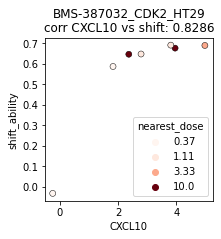

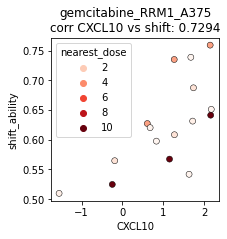

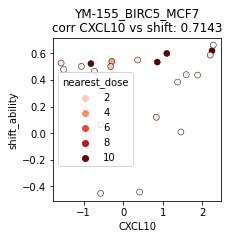

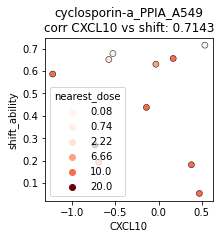

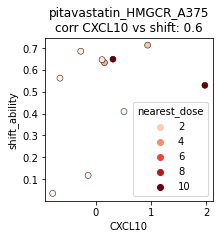

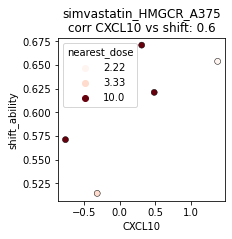

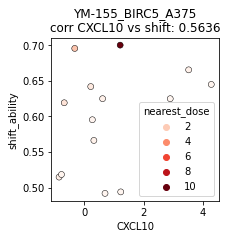

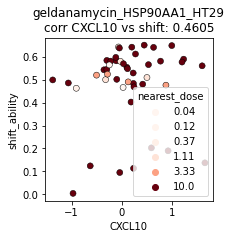

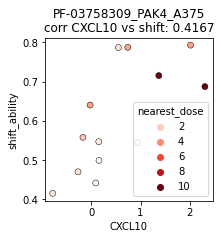

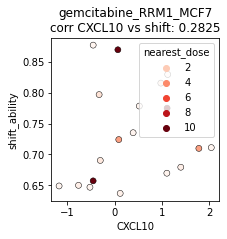

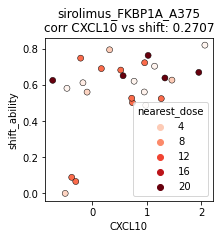

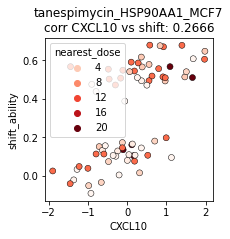

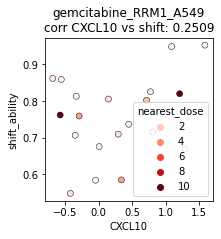

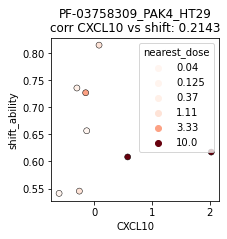

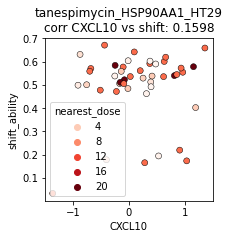

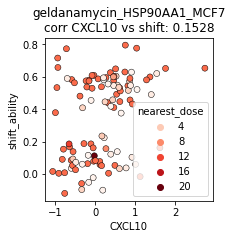

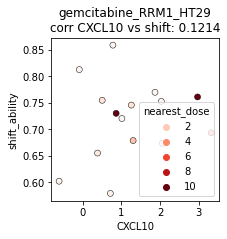

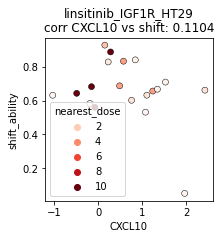

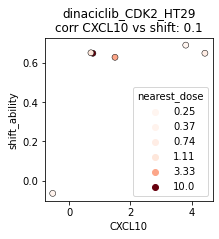

In [183]:
for t in cand_pairs.index:
    tmp_d = t.split('_')[0]
    tmp_s = t.split('_')[1]
    tmp_c = t.split('_')[2]
    
    tmp_d_shift = sub_compound[sub_compound['cmap_name'] == tmp_d]
    tmp_d_shift = tmp_d_shift[tmp_d_shift['cell_line'] == tmp_c]
    
    tmp_cxcl10 = cxcl10_expr[cxcl10_expr.index.isin(tmp_d_shift.index)]
    
    tmp_concat = pd.concat([df(tmp_cxcl10['CXCL10']), df(tmp_d_shift['shift_ability']), df(tmp_d_shift['nearest_dose'])], axis=1)
    
    plt.figure(figsize=(3, 3))
    sns.scatterplot(x='CXCL10', y='shift_ability', hue='nearest_dose', edgecolor='k', data=tmp_concat, palette='Reds')
    plt.title(t + '\ncorr CXCL10 vs shift: ' + str(np.round(cand_pairs.loc[t, 'CXCL10_shift_corr'], 4)))
    fig = plt.gcf()
    fig.savefig(poseidon_home + 'bi_target/top_CXCL10_corr/dose_' + t + '.png', dpi=300, transparent=True)
    fig.savefig(poseidon_home + 'bi_target/top_CXCL10_corr/dose_' + t + '.pdf', transparent=True)

In [179]:
sub_compound

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,target,cell_line
REP.A019_MDAMB231_24H:L13,-0.445946,0.507214,dasatinib,10.000,10 uM,0.953159,BRCA,EPHA2,MDAMB231
REP.A019_MDAMB231_24H:L16,-0.428393,0.490055,dasatinib,0.370,0.37 uM,0.918448,BRCA,EPHA2,MDAMB231
REP.A023_MCF7_24H:O15,-0.503013,0.412289,valrubicin,1.110,1.11 uM,0.915302,BRCA,TOP2A,MCF7
REP.A015_MCF7_24H:E11,-0.473579,0.441700,epirubicin,0.125,0.125 uM,0.915279,BRCA,TOP2A,MCF7
REP.A019_MDAMB231_24H:L15,-0.431697,0.477136,dasatinib,1.110,1.11 uM,0.908832,BRCA,EPHA2,MDAMB231
...,...,...,...,...,...,...,...,...,...
CPC006_AGS_6H:BRD-K00615600-001-06-1:25,0.162865,-0.232796,AG-14361,25.000,25 uM,-0.395661,STAD,PARP1,AGS
CPC006_AGS_6H:BRD-K71726959-001-06-7:122.55,0.207590,-0.332709,BRD-K71726959,125.000,125 uM,-0.540300,STAD,CDK5,AGS
CPC006_SNGM_6H:BRD-K64890080-001-03-9:10,-0.262499,0.338284,BI-2536,10.000,10 uM,0.600783,UCEC,PLK1,SNGM
CPC006_HEC108_6H:N01,-0.318334,0.218222,idarubicin,0.080,0.08 uM,0.536556,UCEC,TOP2A,HEC108


# short list
    gemcitabine RRM1 A375, MCF7, A549
    pitavastatin/simvastatin MHGCR A375 (~statins)
    PF-03758309 PAK4 A375, HT29
    tanespimycin (orphan drug, 17-AAG) HSP90AA1 MCF7, HT29
    dinaciclib CDK2 HT29

In [47]:
cand_pairs_target = list(cand_pairs['target'].unique())

In [48]:
cand_pairs_target

['CDK2',
 'RRM1',
 'BIRC5',
 'PPIA',
 'HMGCR',
 'HSP90AA1',
 'PAK4',
 'FKBP1A',
 'IGF1R']

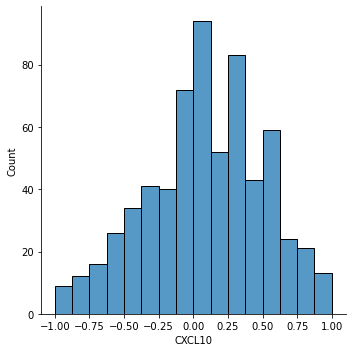

In [49]:
sns.displot(icd_corr['CXCL10'])

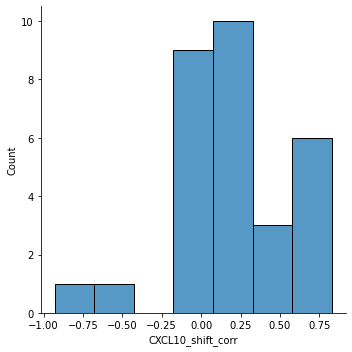

In [50]:
sns.displot(top_ave_shift_cxcl10['CXCL10_shift_corr'])

# 3. Corr between 25 targets and TCGA immune response

In [96]:
expr_cbio = pd.read_csv(cbio_home + 'mRNA_Expression_RSEM_batch_normalized.txt', header=0, index_col=1, sep='\t')

In [97]:
expr_cbio = expr_cbio.dropna(axis=0, how='any').fillna(0)
print(expr_cbio.shape)

(8391, 41)


In [98]:
expr_cbio

,STUDY_ID,CDK2,RRM1,BIRC5,PPIA,HMGCR,HSP90AA1,PAK4,FKBP1A,IGF1R,...,GZMA,GZMB,IFNA1,IFNB1,CXCL10,CD274,IRF3,IRF7,IFI16,STING1
SAMPLE_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1-01,acc_tcga_pan_can_atlas_2018,338.617,922.190,49.4717,7085.01,9138.3300,20979.30,2161.38,7105.67,213.737,...,35.0624,11.0471,0.0,0.0000,22.0941,1.9212,558.132,190.2020,394.813,81.1720
TCGA-OR-A5J2-01,acc_tcga_pan_can_atlas_2018,1161.990,1757.080,68.0727,5507.18,6705.0000,18527.40,1561.40,3870.54,4073.410,...,17.7157,4.0263,0.0,0.0000,16.1052,5.2342,897.487,53.1472,1453.090,198.8990
TCGA-OR-A5J3-01,acc_tcga_pan_can_atlas_2018,505.407,1757.370,53.9653,8564.66,19344.7000,26035.80,2671.01,3635.02,428.974,...,3.5550,6.5176,0.0,0.0000,2.9625,3.5550,1270.580,26.0702,2295.960,100.7260
TCGA-OR-A5J5-01,acc_tcga_pan_can_atlas_2018,1754.450,834.237,780.6740,7408.99,3789.3100,14796.30,3479.47,3140.20,2546.860,...,17.8156,14.7173,0.0,0.0000,9.2951,3.0984,2345.760,66.6150,804.028,34.0821
TCGA-OR-A5J6-01,acc_tcga_pan_can_atlas_2018,210.689,1859.880,6.2983,7628.95,16240.4000,23790.00,1290.40,6874.50,2685.870,...,32.9725,19.0011,0.0,0.0000,27.3840,1.6766,1337.470,67.0628,1144.540,193.3640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-V4-A9F3-01,uvm_tcga_pan_can_atlas_2018,5415.540,992.507,78.0176,5117.96,937.2730,31773.50,1982.44,3286.32,5026.330,...,251.7660,92.9137,0.0,0.4282,587.8830,65.0824,936.091,520.2310,1325.200,2508.2400
TCGA-V4-A9EY-01,uvm_tcga_pan_can_atlas_2018,12575.200,165.860,34.1726,8838.54,94.5811,6049.08,7419.82,7740.57,4812.670,...,4.1122,4.1122,0.0,0.0000,2.7415,5.4830,1609.500,264.5530,213.836,4868.8700
TCGA-V4-A9E5-01,uvm_tcga_pan_can_atlas_2018,14807.400,562.599,113.1770,7025.36,275.7530,8872.42,4513.47,4402.54,6201.270,...,3.9620,3.1696,0.0,0.0000,0.7924,5.5468,1365.130,336.7670,1233.760,622.8210


In [99]:
# sample size
expr_cbio['STUDY_ID'].value_counts()

brca_tcga_pan_can_atlas_2018        1082
hnsc_tcga_pan_can_atlas_2018         515
lgg_tcga_pan_can_atlas_2018          514
kirc_tcga_pan_can_atlas_2018         510
luad_tcga_pan_can_atlas_2018         510
thca_tcga_pan_can_atlas_2018         498
lusc_tcga_pan_can_atlas_2018         484
prad_tcga_pan_can_atlas_2018         460
skcm_tcga_pan_can_atlas_2018         443
blca_tcga_pan_can_atlas_2018         407
lihc_tcga_pan_can_atlas_2018         366
coadread_tcga_pan_can_atlas_2018     365
cesc_tcga_pan_can_atlas_2018         294
kirp_tcga_pan_can_atlas_2018         283
sarc_tcga_pan_can_atlas_2018         253
pcpg_tcga_pan_can_atlas_2018         178
paad_tcga_pan_can_atlas_2018         177
ucec_tcga_pan_can_atlas_2018         173
gbm_tcga_pan_can_atlas_2018          160
tgct_tcga_pan_can_atlas_2018         149
thym_tcga_pan_can_atlas_2018         119
meso_tcga_pan_can_atlas_2018          87
uvm_tcga_pan_can_atlas_2018           80
acc_tcga_pan_can_atlas_2018           78
kich_tcga_pan_ca

In [100]:
expr_cbio_palette = df(index=expr_cbio.columns, columns=['category', 'color'])
for g in expr_cbio_palette.index:
    if g in top_ave_shift['target'].unique():
        expr_cbio_palette.at[g, 'category'] = 'hi-synergy_target'
        expr_cbio_palette.at[g, 'color'] = 'crimson'
    elif g in ['TAP1', 'TAP2', 'B2M', 'HLA-A', 'HLA-B', 'HLA-C', 'GZMA', 'GZMB', 'CD274']:
        expr_cbio_palette.at[g, 'category'] = 'MHC.I'
        expr_cbio_palette.at[g, 'color'] = 'navajowhite'
    elif g in ['IFNA1', 'IFNB1', 'CXCL10','IRF3', 'IRF7', 'IFI16', 'STING1',]:
        expr_cbio_palette.at[g, 'category'] = 'Type I IFN'
        expr_cbio_palette.at[g, 'color'] = 'paleturquoise'

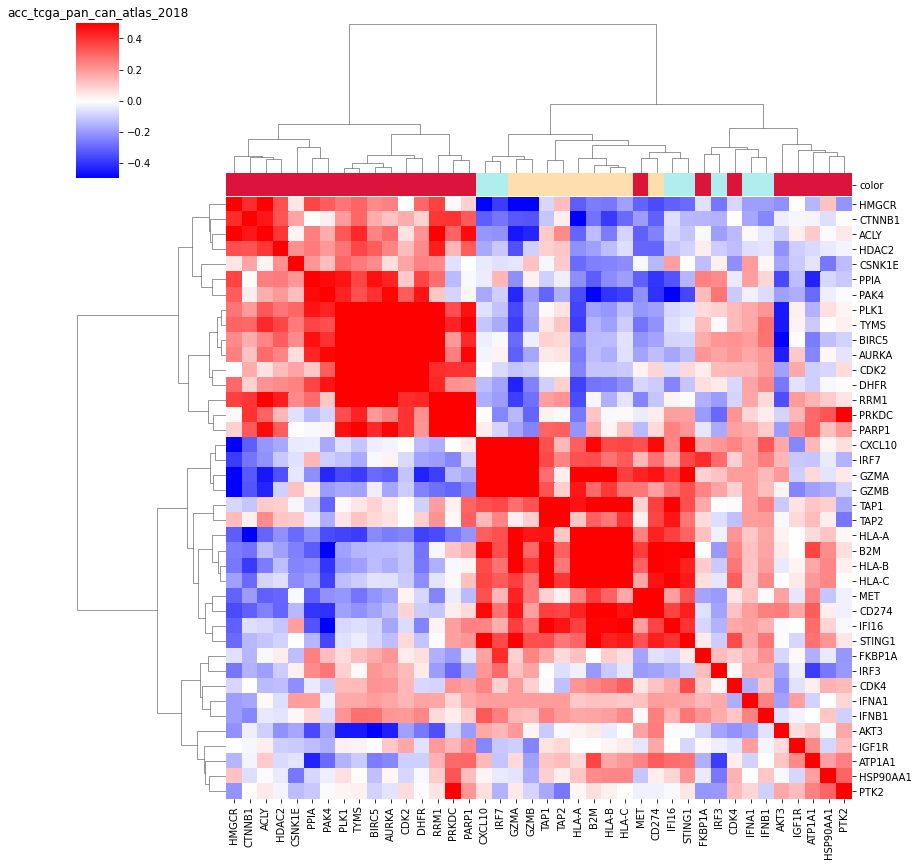

CDK2        0.316810
RRM1        0.110333
BIRC5       0.406088
PPIA        0.478496
HMGCR       0.318934
HSP90AA1   -0.035142
PAK4        1.000000
FKBP1A      0.131931
IGF1R      -0.159069
AURKA       0.484819
CDK4       -0.103454
PLK1        0.432188
DHFR        0.464207
TYMS        0.343644
ACLY        0.159094
PRKDC      -0.082361
AKT3       -0.187243
HDAC2       0.202721
PARP1       0.020676
ATP1A1     -0.289546
PTK2       -0.009193
MET        -0.217567
CSNK1E      0.125229
CTNNB1      0.033448
TAP1       -0.301079
TAP2       -0.156616
B2M        -0.494657
HLA-A      -0.349891
HLA-B      -0.397236
HLA-C      -0.372248
GZMA       -0.422198
GZMB       -0.194324
IFNA1      -0.027839
IFNB1      -0.067599
CXCL10     -0.169615
CD274      -0.405617
IRF3        0.270552
IRF7       -0.096802
IFI16      -0.537298
STING1     -0.360589
Name: PAK4, dtype: float64


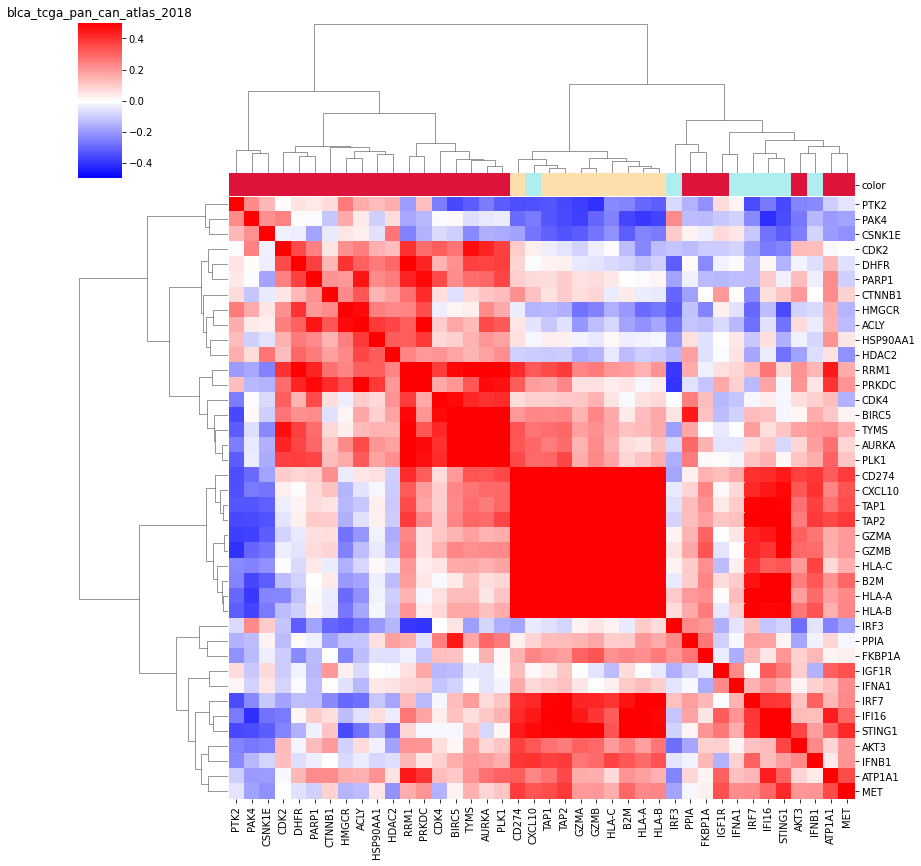

CDK2        0.242694
RRM1       -0.170843
BIRC5       0.015018
PPIA       -0.131941
HMGCR       0.166526
HSP90AA1   -0.093007
PAK4        1.000000
FKBP1A     -0.134583
IGF1R      -0.107609
AURKA      -0.046338
CDK4       -0.008715
PLK1       -0.035954
DHFR        0.006763
TYMS       -0.065364
ACLY        0.042148
PRKDC      -0.140045
AKT3       -0.262062
HDAC2       0.068201
PARP1      -0.006295
ATP1A1     -0.197146
PTK2        0.230240
MET        -0.181923
CSNK1E      0.218214
CTNNB1     -0.111465
TAP1       -0.328717
TAP2       -0.353788
B2M        -0.361188
HLA-A      -0.388724
HLA-B      -0.366467
HLA-C      -0.242501
GZMA       -0.374493
GZMB       -0.297193
IFNA1      -0.088584
IFNB1      -0.138236
CXCL10     -0.257998
CD274      -0.292465
IRF3        0.228002
IRF7       -0.230687
IFI16      -0.406300
STING1     -0.349397
Name: PAK4, dtype: float64


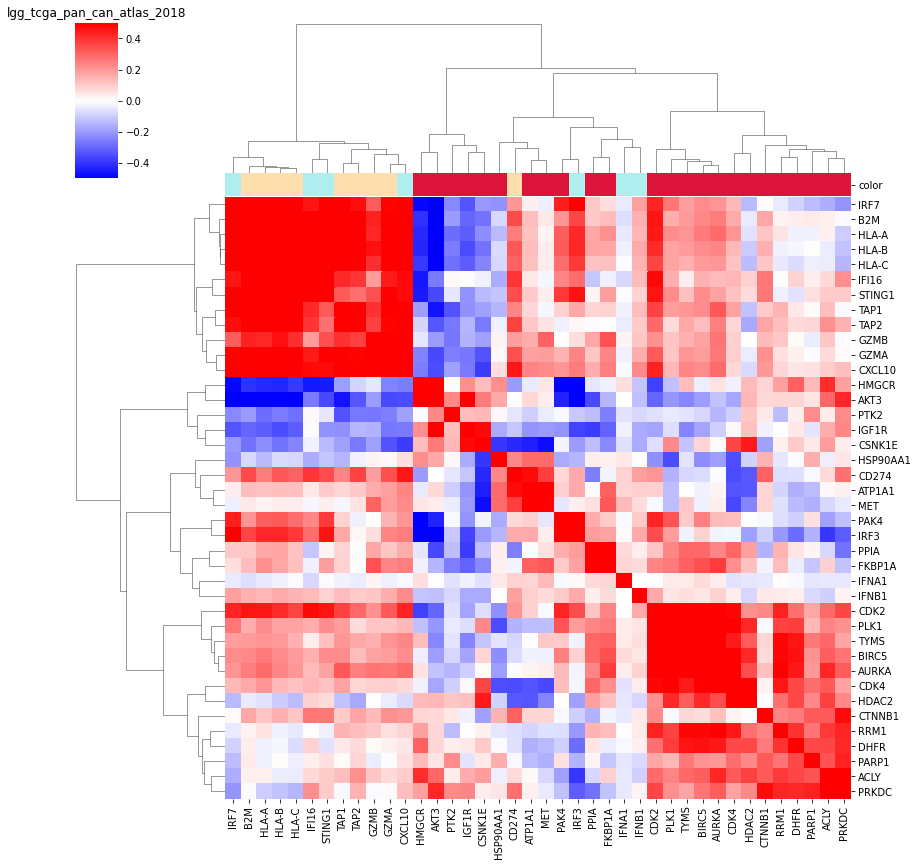

CDK2        0.429563
RRM1       -0.064485
BIRC5       0.248245
PPIA        0.162191
HMGCR      -0.608725
HSP90AA1   -0.167052
PAK4        1.000000
FKBP1A      0.102619
IGF1R      -0.207299
AURKA       0.136282
CDK4        0.127043
PLK1        0.332821
DHFR       -0.092255
TYMS        0.104387
ACLY       -0.187078
PRKDC      -0.121805
AKT3       -0.433541
HDAC2      -0.002779
PARP1       0.060871
ATP1A1      0.095261
PTK2       -0.013293
MET        -0.050529
CSNK1E     -0.019856
CTNNB1     -0.013765
TAP1        0.088460
TAP2       -0.029293
B2M         0.208346
HLA-A       0.315439
HLA-B       0.321676
HLA-C       0.283758
GZMA        0.145806
GZMB        0.007259
IFNA1      -0.013646
IFNB1       0.104350
CXCL10      0.205663
CD274       0.076929
IRF3        0.723604
IRF7        0.437938
IFI16       0.235449
STING1      0.388826
Name: PAK4, dtype: float64


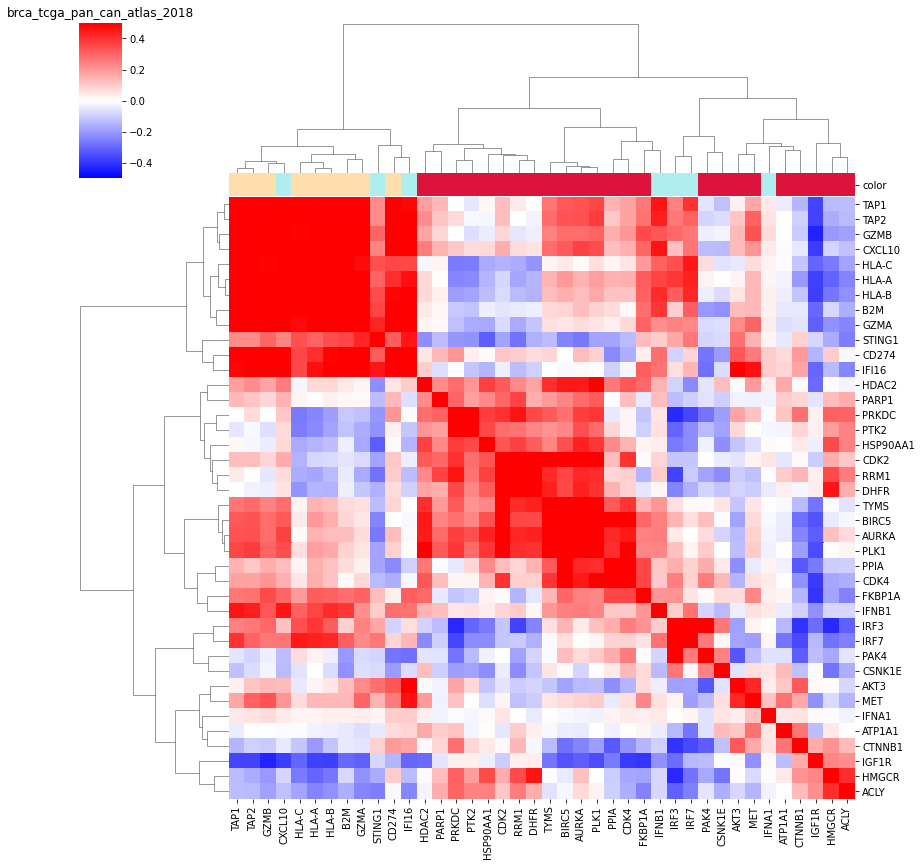

CDK2       -0.003757
RRM1       -0.180575
BIRC5       0.128164
PPIA        0.160792
HMGCR      -0.171532
HSP90AA1   -0.030029
PAK4        1.000000
FKBP1A      0.009219
IGF1R      -0.130817
AURKA       0.068492
CDK4        0.256706
PLK1        0.104923
DHFR       -0.084483
TYMS       -0.008934
ACLY       -0.051116
PRKDC      -0.271386
AKT3       -0.330574
HDAC2      -0.051311
PARP1      -0.054775
ATP1A1     -0.060107
PTK2       -0.135808
MET        -0.128547
CSNK1E      0.242706
CTNNB1     -0.318389
TAP1       -0.053043
TAP2       -0.084548
B2M        -0.202567
HLA-A       0.026570
HLA-B      -0.035006
HLA-C       0.066743
GZMA       -0.073940
GZMB       -0.034373
IFNA1      -0.061884
IFNB1      -0.085522
CXCL10     -0.129613
CD274      -0.273203
IRF3        0.524472
IRF7        0.259436
IFI16      -0.277793
STING1     -0.085110
Name: PAK4, dtype: float64


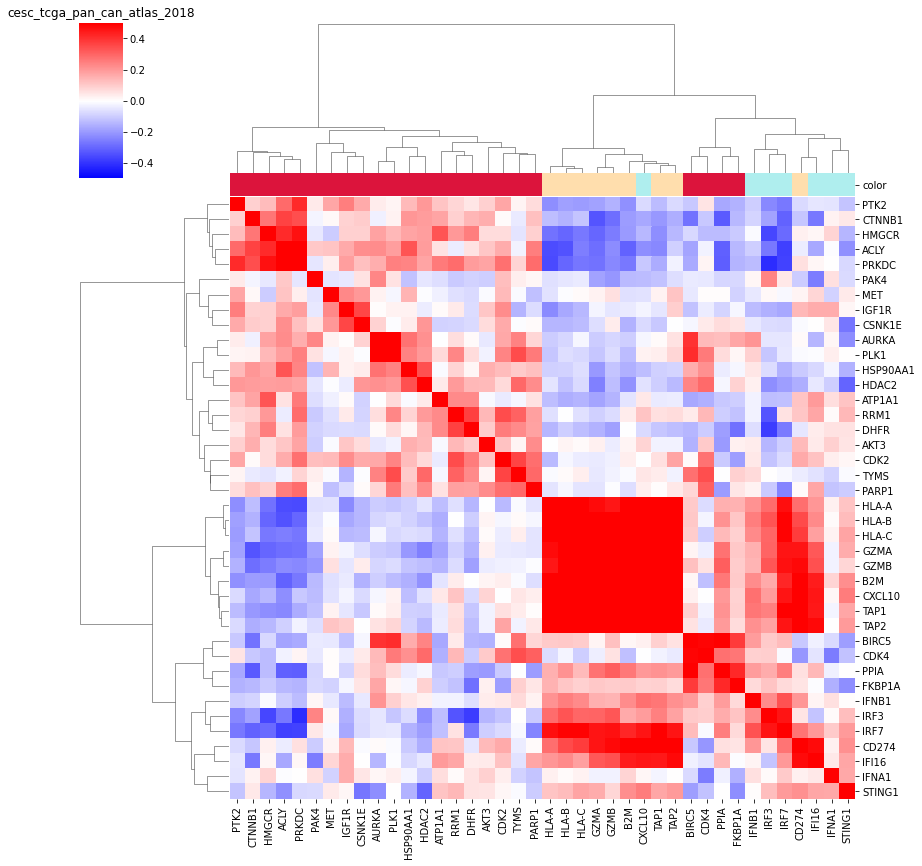

CDK2        0.127454
RRM1       -0.101735
BIRC5      -0.042352
PPIA       -0.081564
HMGCR      -0.045770
HSP90AA1   -0.118410
PAK4        1.000000
FKBP1A     -0.074823
IGF1R      -0.045451
AURKA       0.236687
CDK4       -0.044831
PLK1        0.057523
DHFR       -0.089774
TYMS        0.034597
ACLY        0.107554
PRKDC      -0.048005
AKT3       -0.097565
HDAC2      -0.049928
PARP1       0.017168
ATP1A1     -0.062717
PTK2        0.042901
MET        -0.054248
CSNK1E      0.056060
CTNNB1     -0.019979
TAP1       -0.119973
TAP2       -0.063977
B2M        -0.134294
HLA-A      -0.061652
HLA-B      -0.048980
HLA-C      -0.041959
GZMA       -0.183517
GZMB       -0.206222
IFNA1       0.058767
IFNB1       0.017451
CXCL10     -0.132198
CD274      -0.100148
IRF3        0.241275
IRF7        0.044702
IFI16      -0.255644
STING1     -0.072726
Name: PAK4, dtype: float64


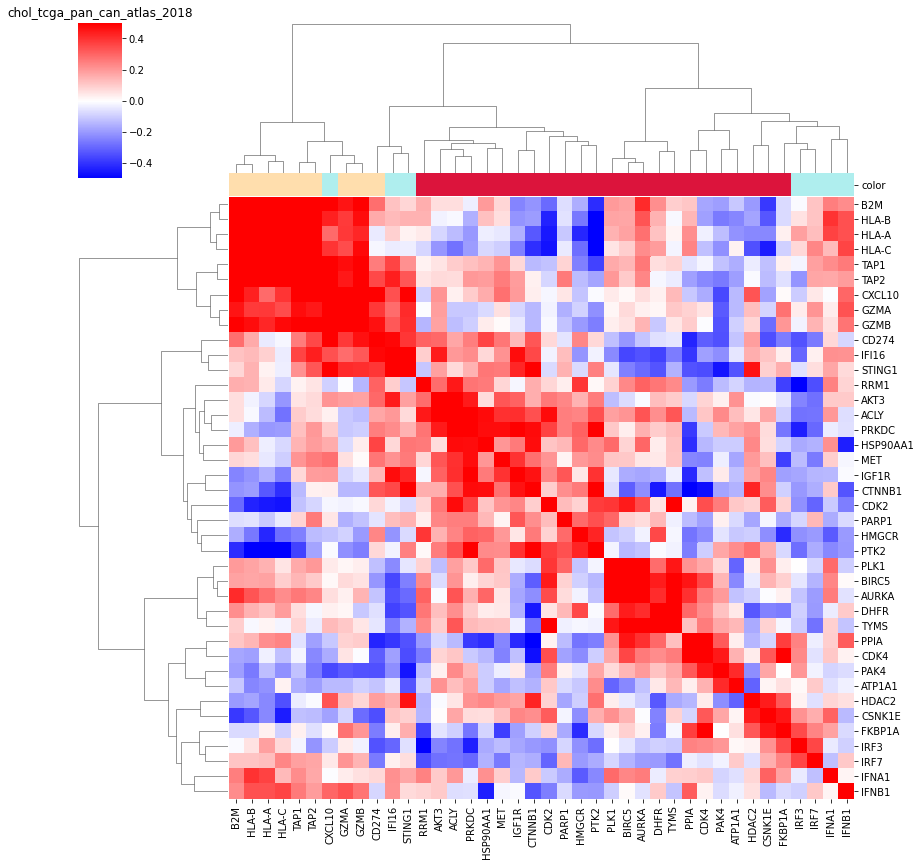

CDK2        0.256628
RRM1       -0.129730
BIRC5       0.143372
PPIA        0.322780
HMGCR      -0.050965
HSP90AA1   -0.101158
PAK4        1.000000
FKBP1A      0.001287
IGF1R       0.042728
AURKA       0.198713
CDK4        0.451995
PLK1        0.072844
DHFR        0.119691
TYMS        0.169112
ACLY        0.227542
PRKDC       0.140283
AKT3        0.028829
HDAC2      -0.218790
PARP1       0.029858
ATP1A1      0.415701
PTK2        0.175290
MET        -0.031403
CSNK1E      0.173488
CTNNB1     -0.178893
TAP1       -0.118662
TAP2       -0.259459
B2M        -0.189189
HLA-A      -0.126641
HLA-B      -0.259974
HLA-C      -0.214929
GZMA       -0.320721
GZMB       -0.339254
IFNA1      -0.082542
IFNB1      -0.067523
CXCL10     -0.358044
CD274      -0.341570
IRF3        0.206178
IRF7       -0.025483
IFI16      -0.220592
STING1     -0.459459
Name: PAK4, dtype: float64


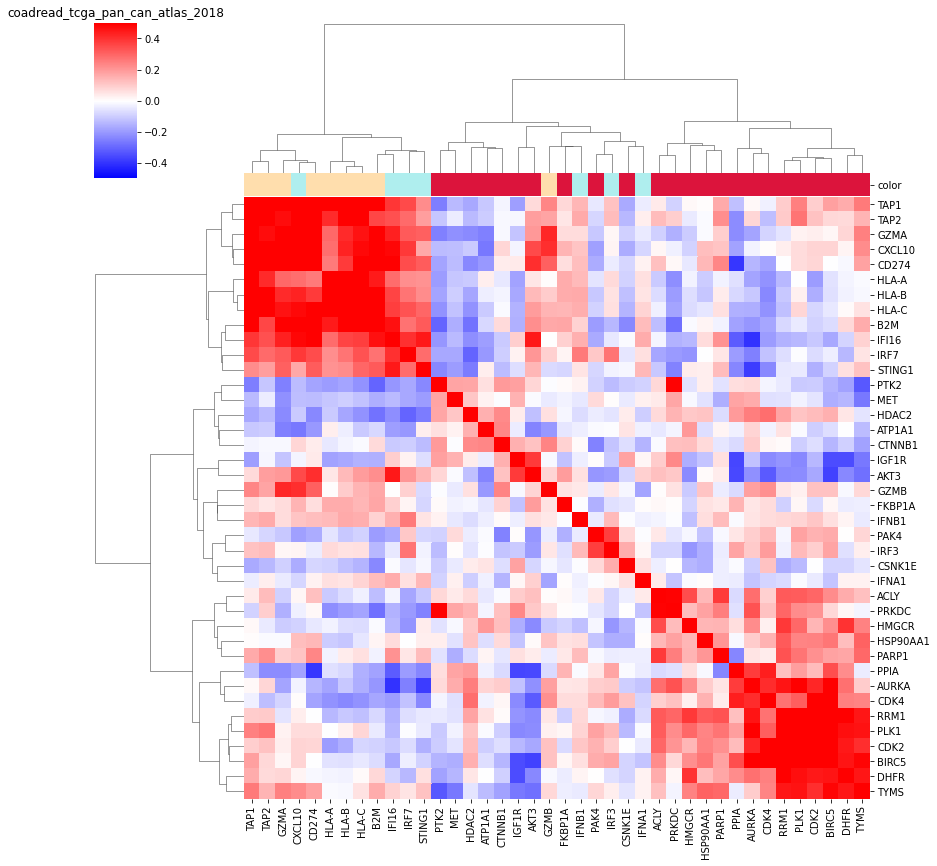

CDK2        0.151994
RRM1       -0.016270
BIRC5       0.160323
PPIA        0.048283
HMGCR      -0.015983
HSP90AA1   -0.116036
PAK4        1.000000
FKBP1A     -0.154824
IGF1R       0.007370
AURKA       0.096182
CDK4        0.133458
PLK1        0.182523
DHFR        0.001704
TYMS        0.078962
ACLY        0.045114
PRKDC      -0.050121
AKT3       -0.205793
HDAC2      -0.038609
PARP1      -0.013533
ATP1A1     -0.008252
PTK2       -0.087401
MET         0.073399
CSNK1E      0.077401
CTNNB1     -0.243778
TAP1       -0.043632
TAP2       -0.081388
B2M        -0.193216
HLA-A      -0.052603
HLA-B      -0.109095
HLA-C      -0.088062
GZMA       -0.108814
GZMB       -0.035902
IFNA1      -0.004659
IFNB1      -0.039240
CXCL10     -0.184688
CD274      -0.160874
IRF3        0.376368
IRF7        0.106841
IFI16      -0.167937
STING1     -0.080532
Name: PAK4, dtype: float64


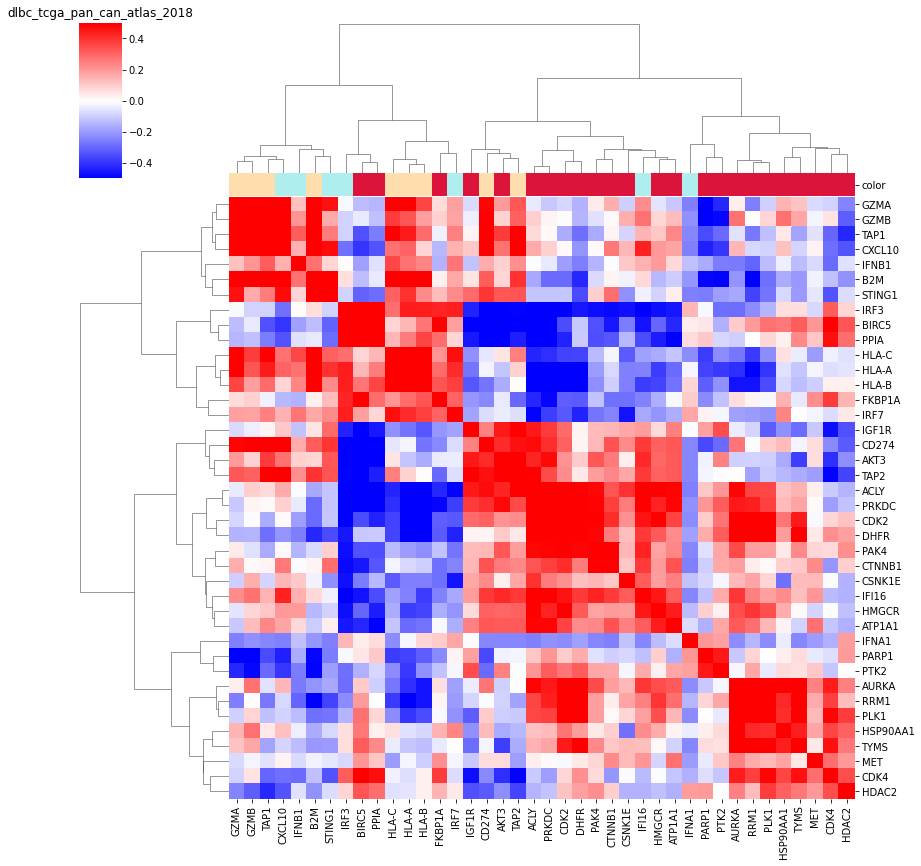

CDK2        0.516826
RRM1        0.188558
BIRC5      -0.341511
PPIA       -0.346505
HMGCR       0.181394
HSP90AA1    0.043422
PAK4        1.000000
FKBP1A     -0.118541
IGF1R       0.134824
AURKA       0.354212
CDK4        0.070452
PLK1        0.190187
DHFR        0.490990
TYMS        0.230677
ACLY        0.486539
PRKDC       0.495983
AKT3        0.328159
HDAC2       0.221233
PARP1      -0.061876
ATP1A1      0.235671
PTK2        0.173252
MET         0.079353
CSNK1E      0.144160
CTNNB1      0.514655
TAP1       -0.166305
TAP2        0.195289
B2M        -0.071537
HLA-A      -0.193226
HLA-B      -0.220908
HLA-C      -0.134824
GZMA        0.040599
GZMB       -0.059488
IFNA1      -0.236907
IFNB1      -0.145577
CXCL10      0.014763
CD274       0.136778
IRF3       -0.476444
IRF7       -0.270517
IFI16       0.432262
STING1      0.097482
Name: PAK4, dtype: float64


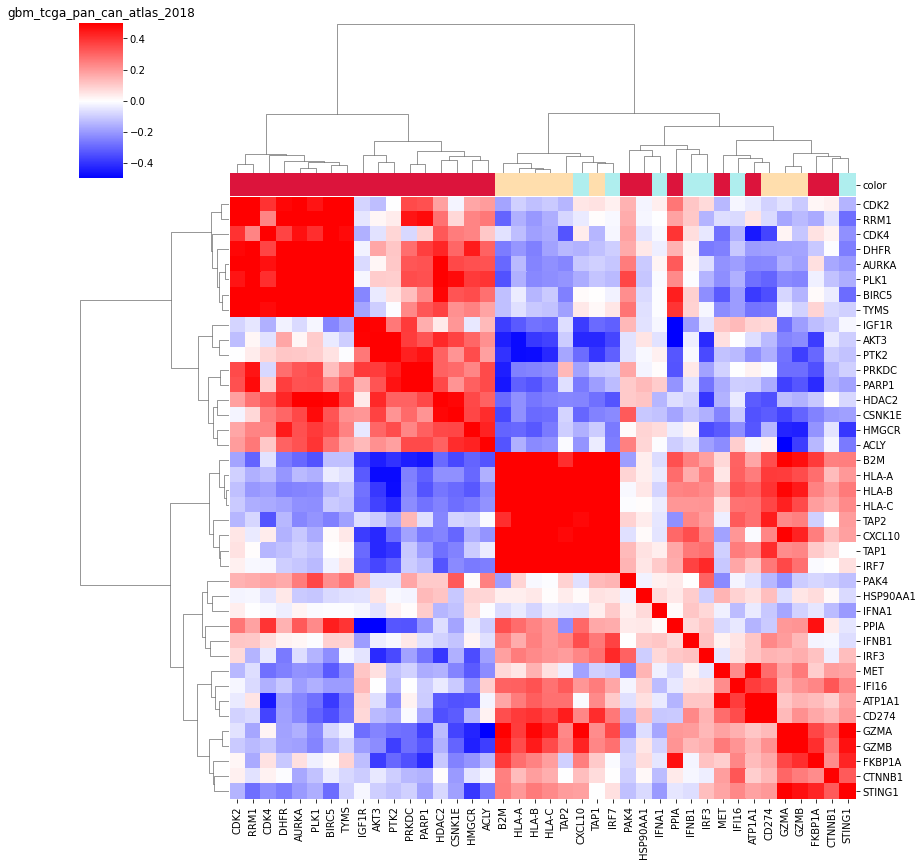

CDK2        0.149517
RRM1        0.161942
BIRC5       0.222489
PPIA        0.039415
HMGCR       0.008239
HSP90AA1   -0.025516
PAK4        1.000000
FKBP1A     -0.080247
IGF1R       0.139286
AURKA       0.256601
CDK4        0.181123
PLK1        0.363152
DHFR        0.164420
TYMS        0.273143
ACLY        0.249414
PRKDC       0.173749
AKT3       -0.057363
HDAC2       0.102698
PARP1       0.101937
ATP1A1     -0.061382
PTK2       -0.055942
MET        -0.227827
CSNK1E      0.324019
CTNNB1     -0.094650
TAP1        0.136142
TAP2        0.088046
B2M        -0.190071
HLA-A       0.083798
HLA-B      -0.011916
HLA-C      -0.007688
GZMA       -0.214144
GZMB       -0.098546
IFNA1       0.029653
IFNB1       0.001842
CXCL10     -0.059472
CD274      -0.137173
IRF3        0.307178
IRF7        0.145163
IFI16      -0.022665
STING1     -0.123488
Name: PAK4, dtype: float64


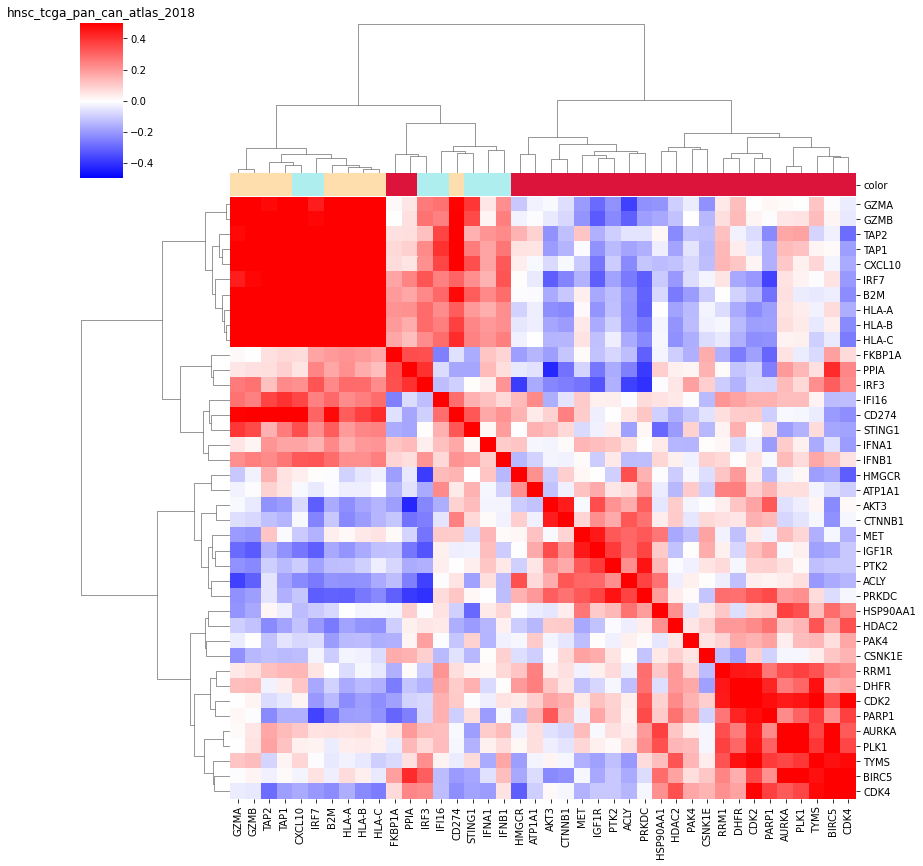

CDK2        0.152062
RRM1        0.085698
BIRC5       0.062836
PPIA        0.022678
HMGCR      -0.018896
HSP90AA1   -0.049259
PAK4        1.000000
FKBP1A     -0.153057
IGF1R       0.005133
AURKA       0.031422
CDK4        0.175597
PLK1        0.132251
DHFR        0.171816
TYMS        0.144513
ACLY        0.027953
PRKDC       0.011712
AKT3       -0.019842
HDAC2       0.049915
PARP1       0.181949
ATP1A1      0.102381
PTK2       -0.029328
MET        -0.128677
CSNK1E      0.053103
CTNNB1     -0.046976
TAP1       -0.053726
TAP2       -0.120708
B2M        -0.192461
HLA-A      -0.135607
HLA-B      -0.132262
HLA-C      -0.156557
GZMA       -0.037710
GZMB        0.000878
IFNA1      -0.145123
IFNB1      -0.027991
CXCL10     -0.074747
CD274      -0.110205
IRF3        0.184381
IRF7       -0.068134
IFI16      -0.005507
STING1      0.086529
Name: PAK4, dtype: float64


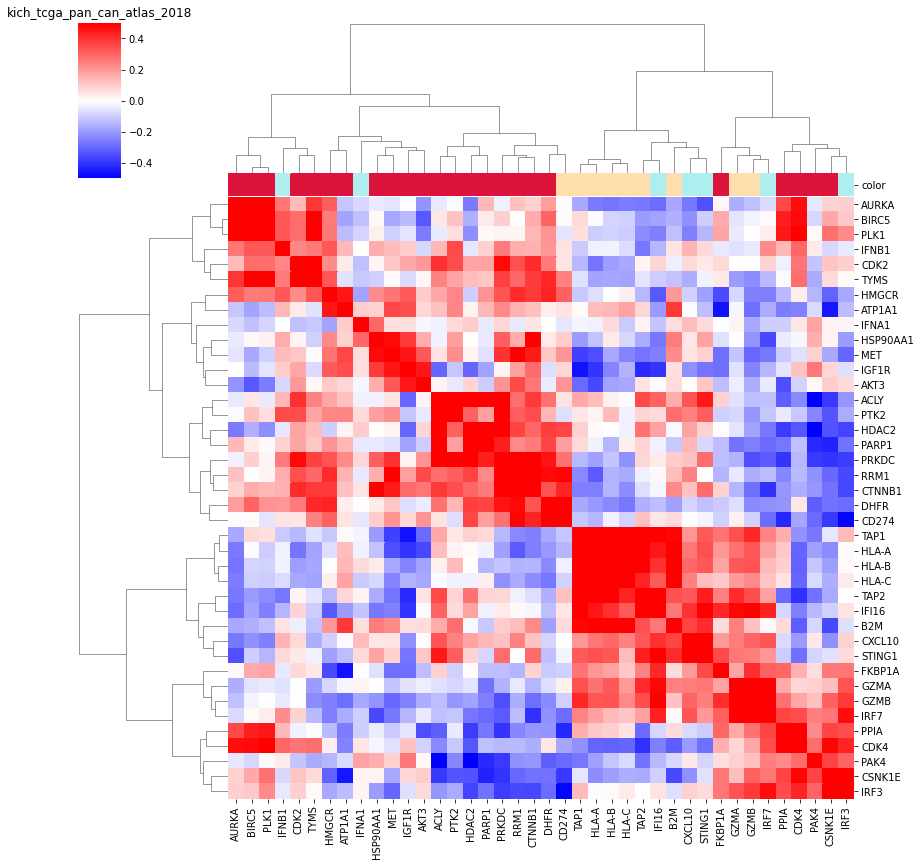

CDK2       -0.117177
RRM1       -0.211320
BIRC5      -0.080288
PPIA        0.227273
HMGCR      -0.141652
HSP90AA1    0.158260
PAK4        1.000000
FKBP1A      0.063199
IGF1R       0.263068
AURKA      -0.049563
CDK4        0.288680
PLK1        0.011014
DHFR       -0.314292
TYMS       -0.164205
ACLY       -0.513374
PRKDC      -0.384135
AKT3        0.017876
HDAC2      -0.531556
PARP1      -0.421766
ATP1A1     -0.073558
PTK2       -0.235664
MET         0.091871
CSNK1E      0.368794
CTNNB1     -0.204283
TAP1       -0.266958
TAP2       -0.274213
B2M        -0.078365
HLA-A      -0.184266
HLA-B      -0.109703
HLA-C      -0.074082
GZMA        0.092963
GZMB        0.123077
IFNA1       0.183274
IFNB1       0.041594
CXCL10      0.043969
CD274      -0.289161
IRF3        0.307037
IRF7        0.250612
IFI16      -0.138199
STING1     -0.085052
Name: PAK4, dtype: float64


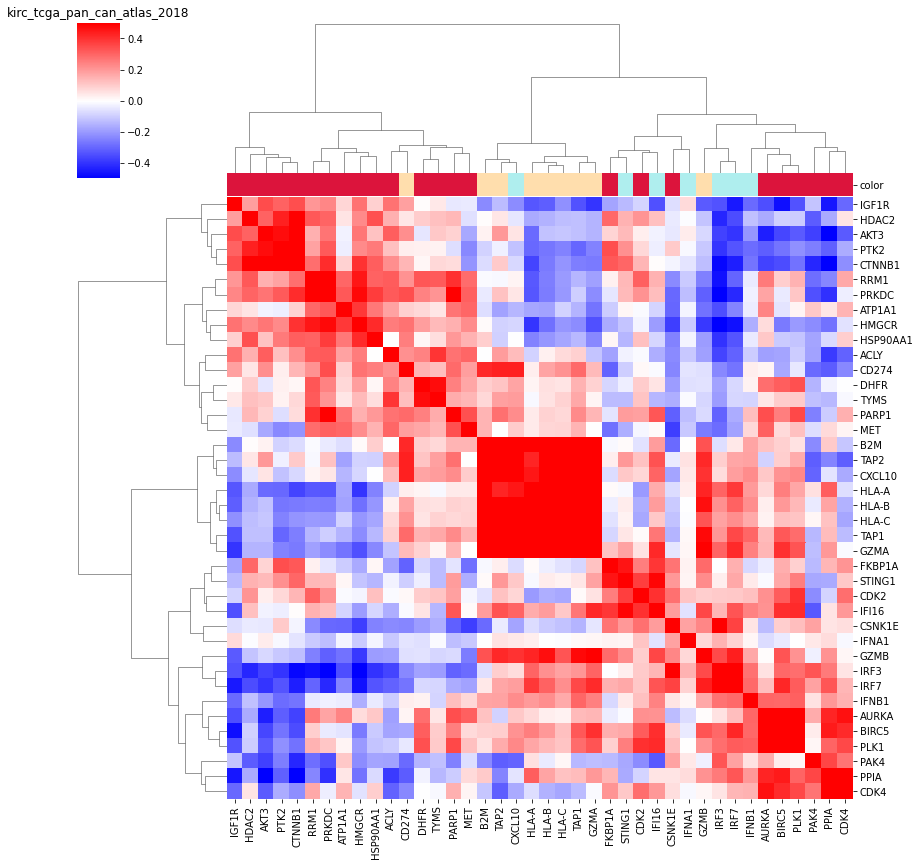

CDK2       -0.222949
RRM1       -0.282174
BIRC5       0.036925
PPIA        0.361186
HMGCR      -0.224449
HSP90AA1   -0.175917
PAK4        1.000000
FKBP1A     -0.136657
IGF1R      -0.115012
AURKA       0.163151
CDK4        0.270954
PLK1        0.015774
DHFR       -0.144773
TYMS       -0.122449
ACLY       -0.182659
PRKDC      -0.341076
AKT3       -0.373293
HDAC2      -0.318918
PARP1      -0.247284
ATP1A1      0.107245
PTK2       -0.250633
MET        -0.062702
CSNK1E      0.183590
CTNNB1     -0.424625
TAP1       -0.137045
TAP2       -0.314375
B2M        -0.226964
HLA-A       0.059614
HLA-B      -0.039526
HLA-C       0.018529
GZMA       -0.126211
GZMB       -0.029845
IFNA1       0.044666
IFNB1       0.058260
CXCL10     -0.302721
CD274      -0.292054
IRF3        0.332125
IRF7        0.181935
IFI16      -0.326663
STING1     -0.171556
Name: PAK4, dtype: float64


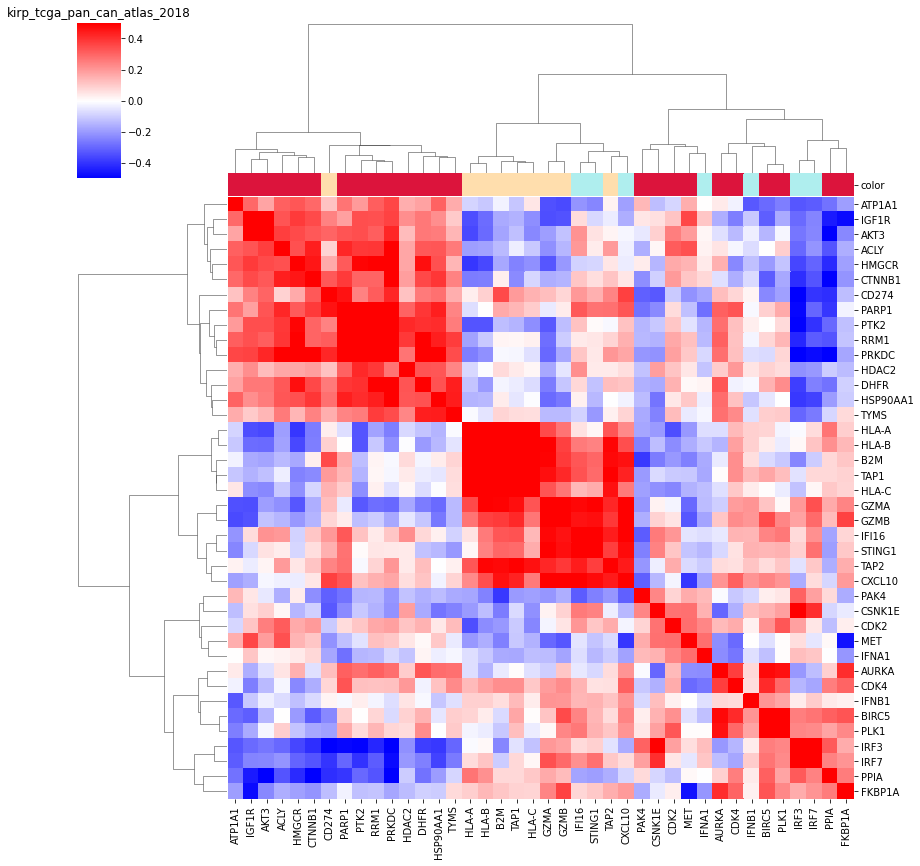

CDK2        0.085474
RRM1       -0.138607
BIRC5       0.034201
PPIA        0.071752
HMGCR       0.036414
HSP90AA1   -0.132735
PAK4        1.000000
FKBP1A     -0.162972
IGF1R       0.048995
AURKA      -0.009609
CDK4       -0.107037
PLK1        0.049834
DHFR       -0.152393
TYMS       -0.166727
ACLY       -0.157844
PRKDC      -0.203267
AKT3       -0.044617
HDAC2      -0.117406
PARP1      -0.276934
ATP1A1      0.137285
PTK2       -0.142858
MET         0.162764
CSNK1E      0.236483
CTNNB1     -0.219445
TAP1       -0.197241
TAP2       -0.203335
B2M        -0.387035
HLA-A      -0.174269
HLA-B      -0.242452
HLA-C      -0.187459
GZMA       -0.205508
GZMB       -0.158069
IFNA1       0.135291
IFNB1      -0.076008
CXCL10     -0.311524
CD274      -0.311437
IRF3        0.307275
IRF7        0.184451
IFI16      -0.319282
STING1     -0.247419
Name: PAK4, dtype: float64


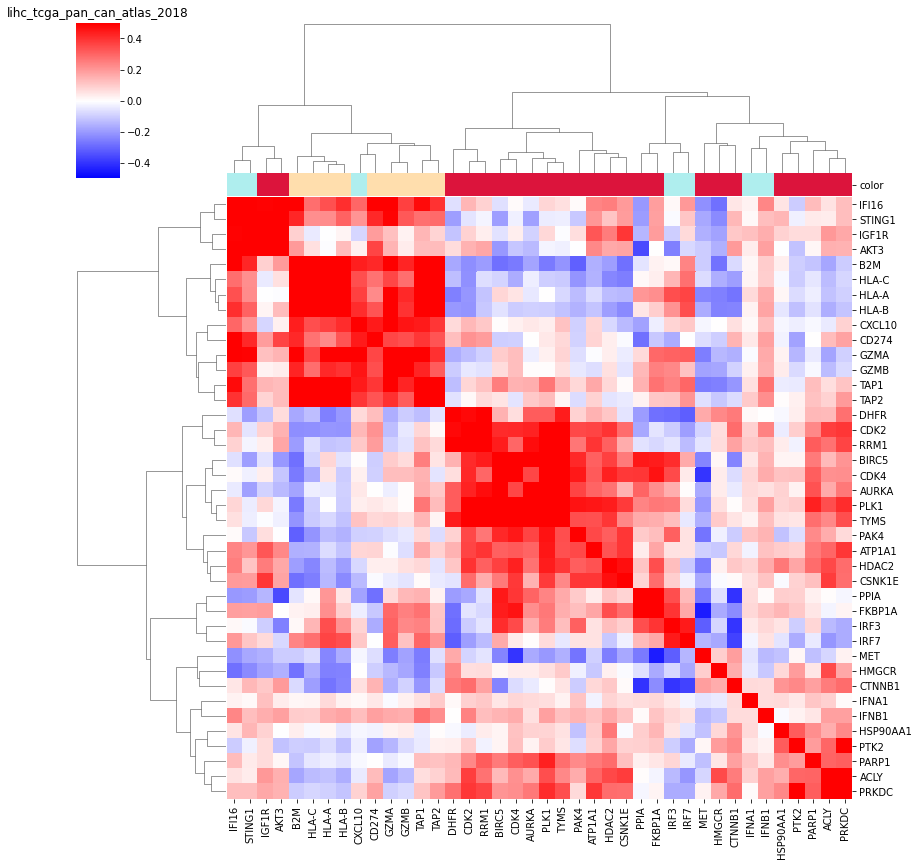

CDK2        0.358381
RRM1        0.266383
BIRC5       0.419767
PPIA        0.102173
HMGCR      -0.027790
HSP90AA1   -0.118370
PAK4        1.000000
FKBP1A      0.126315
IGF1R       0.064889
AURKA       0.364636
CDK4        0.451518
PLK1        0.463974
DHFR        0.088357
TYMS        0.347150
ACLY        0.163019
PRKDC       0.074111
AKT3       -0.000216
HDAC2       0.315622
PARP1       0.227400
ATP1A1      0.358163
PTK2       -0.062631
MET        -0.272339
CSNK1E      0.392762
CTNNB1     -0.101035
TAP1        0.074930
TAP2       -0.067633
B2M        -0.311844
HLA-A      -0.132017
HLA-B      -0.150148
HLA-C      -0.208706
GZMA       -0.064646
GZMB       -0.044338
IFNA1       0.114079
IFNB1       0.147776
CXCL10     -0.090846
CD274      -0.088623
IRF3        0.309092
IRF7        0.056425
IFI16       0.010203
STING1     -0.108481
Name: PAK4, dtype: float64


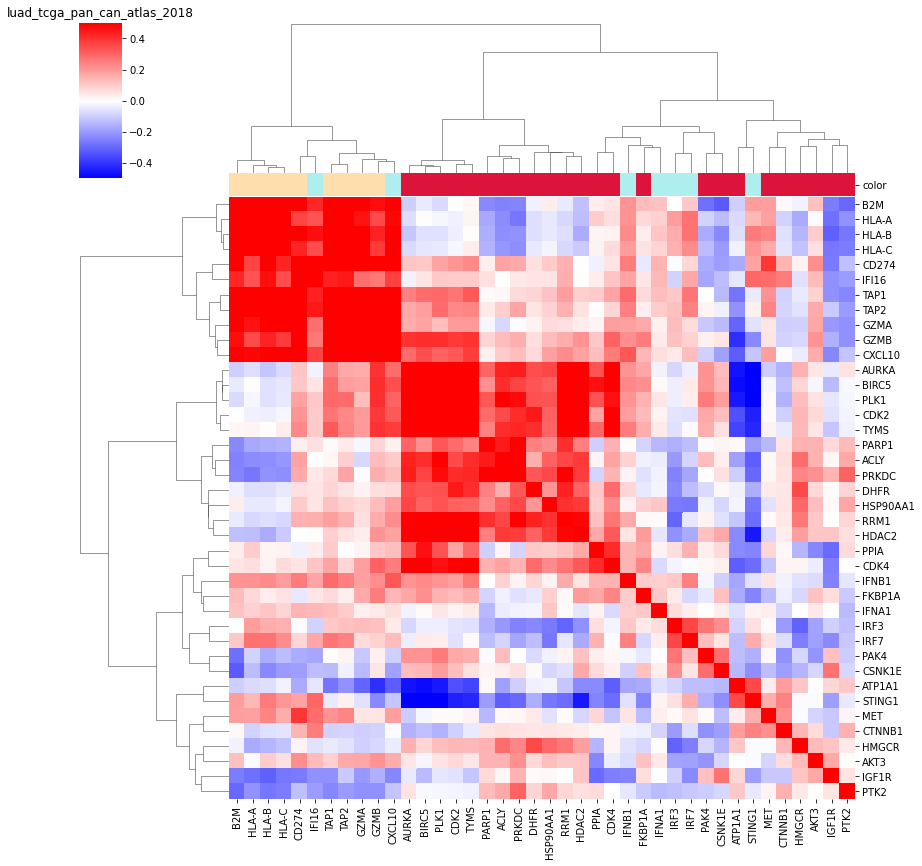

CDK2        0.170082
RRM1        0.023796
BIRC5       0.211207
PPIA        0.032767
HMGCR      -0.080671
HSP90AA1   -0.023683
PAK4        1.000000
FKBP1A     -0.045708
IGF1R       0.123508
AURKA       0.213086
CDK4        0.017730
PLK1        0.258959
DHFR       -0.073854
TYMS        0.158698
ACLY        0.132443
PRKDC       0.001498
AKT3       -0.208990
HDAC2       0.120245
PARP1      -0.008902
ATP1A1     -0.127185
PTK2       -0.100495
MET         0.008288
CSNK1E      0.281419
CTNNB1     -0.215345
TAP1        0.003817
TAP2        0.021003
B2M        -0.277388
HLA-A      -0.088316
HLA-B      -0.163372
HLA-C      -0.131689
GZMA       -0.105507
GZMB        0.028248
IFNA1      -0.002827
IFNB1      -0.018325
CXCL10     -0.090320
CD274      -0.162423
IRF3        0.272745
IRF7        0.125260
IFI16      -0.174653
STING1     -0.154416
Name: PAK4, dtype: float64


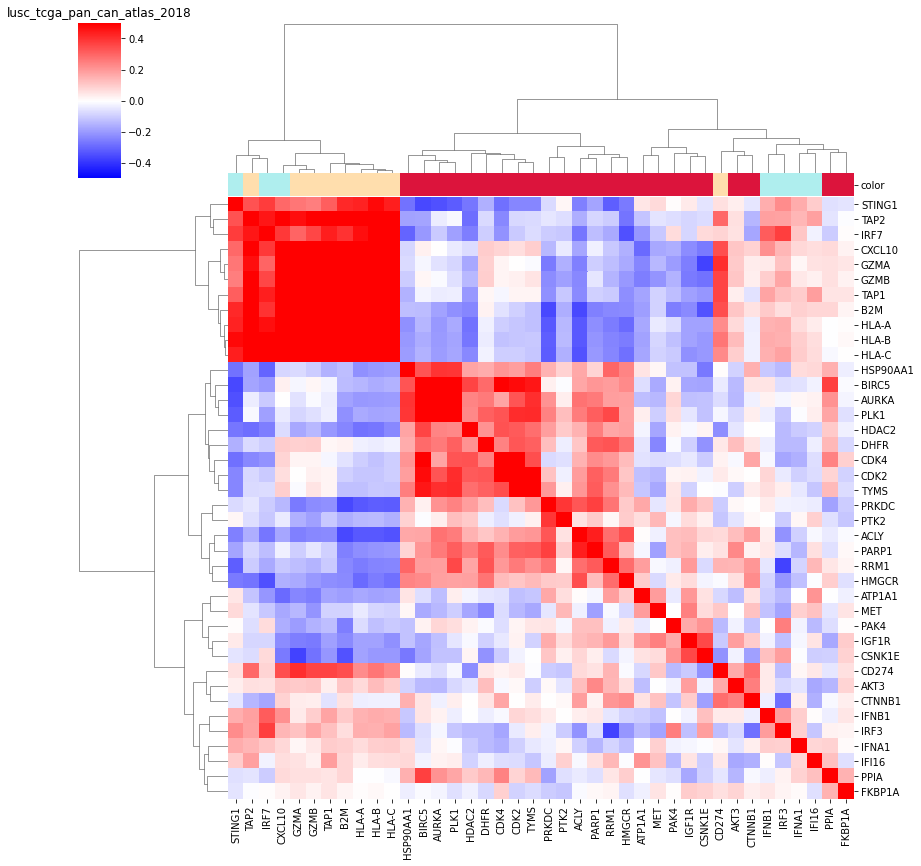

CDK2        0.023421
RRM1       -0.029183
BIRC5       0.025148
PPIA       -0.065090
HMGCR       0.041290
HSP90AA1   -0.119600
PAK4        1.000000
FKBP1A      0.005917
IGF1R       0.166817
AURKA       0.078231
CDK4       -0.063353
PLK1        0.066211
DHFR       -0.010433
TYMS        0.050154
ACLY        0.124195
PRKDC       0.051814
AKT3       -0.024393
HDAC2       0.026735
PARP1       0.124853
ATP1A1     -0.039864
PTK2       -0.017040
MET         0.002249
CSNK1E      0.209866
CTNNB1     -0.117056
TAP1       -0.126163
TAP2       -0.062524
B2M        -0.250078
HLA-A      -0.068824
HLA-B      -0.123621
HLA-C      -0.104077
GZMA       -0.193643
GZMB       -0.152162
IFNA1      -0.026765
IFNB1       0.003051
CXCL10     -0.156971
CD274      -0.133035
IRF3        0.253460
IRF7        0.069189
IFI16      -0.133777
STING1      0.004166
Name: PAK4, dtype: float64


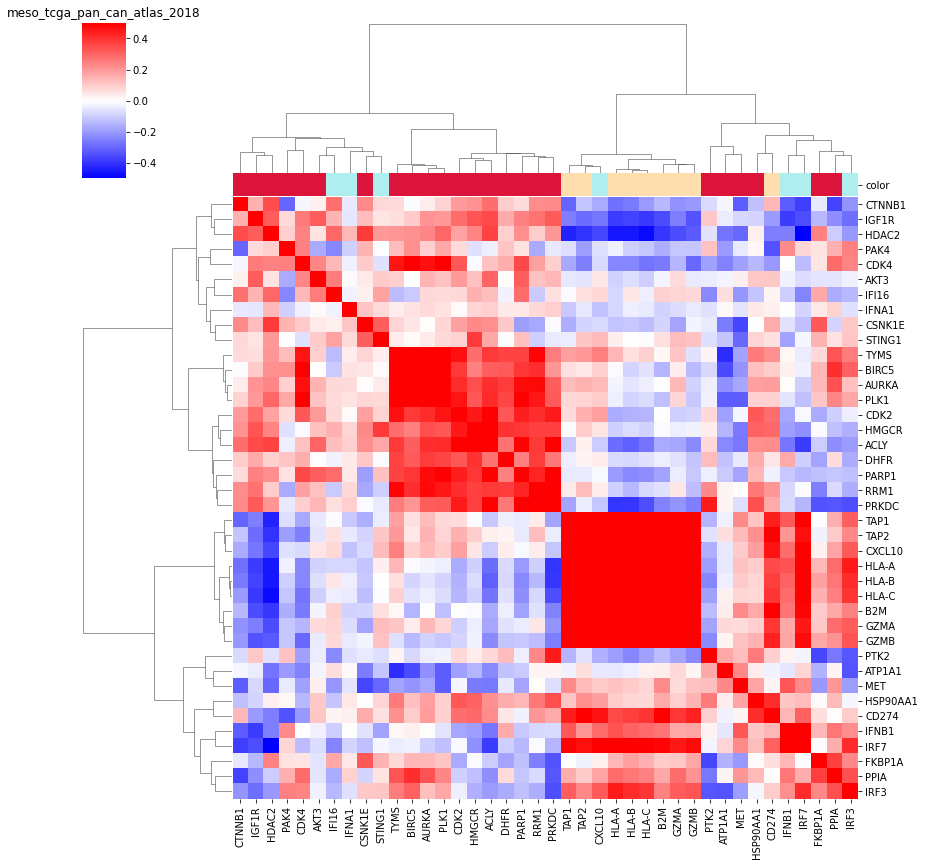

CDK2        0.072520
RRM1       -0.167165
BIRC5       0.220803
PPIA        0.154298
HMGCR      -0.062094
HSP90AA1    0.019465
PAK4        1.000000
FKBP1A      0.055588
IGF1R       0.072392
AURKA       0.096176
CDK4        0.246227
PLK1        0.168222
DHFR        0.116334
TYMS        0.130677
ACLY       -0.033280
PRKDC      -0.044434
AKT3       -0.166345
HDAC2       0.095794
PARP1       0.057720
ATP1A1     -0.199023
PTK2        0.119979
MET        -0.041882
CSNK1E      0.148356
CTNNB1     -0.299136
TAP1       -0.064245
TAP2       -0.190147
B2M        -0.157050
HLA-A      -0.030491
HLA-B      -0.095338
HLA-C      -0.112178
GZMA       -0.111559
GZMB       -0.109973
IFNA1      -0.093524
IFNB1       0.229638
CXCL10     -0.061730
CD274      -0.336025
IRF3        0.249982
IRF7        0.078917
IFI16      -0.236732
STING1     -0.003335
Name: PAK4, dtype: float64


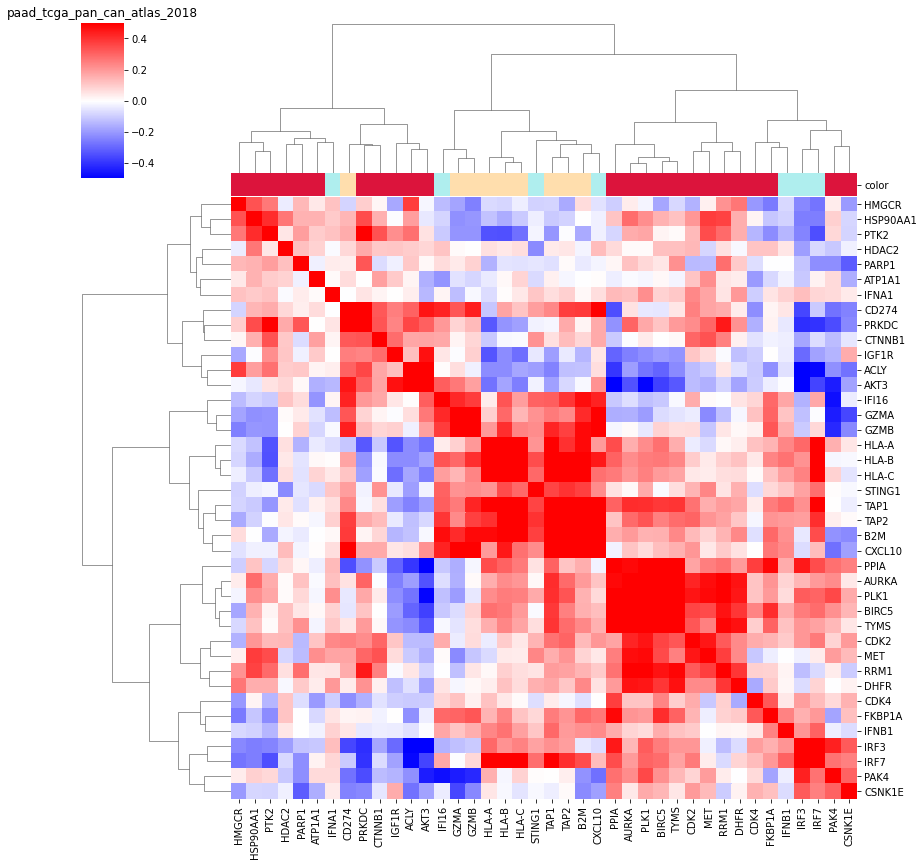

CDK2        0.082889
RRM1        0.038757
BIRC5       0.216889
PPIA        0.280908
HMGCR       0.035857
HSP90AA1    0.089907
PAK4        1.000000
FKBP1A     -0.175863
IGF1R      -0.145715
AURKA       0.223200
CDK4        0.070443
PLK1        0.356744
DHFR       -0.001086
TYMS        0.136920
ACLY       -0.218114
PRKDC      -0.351496
AKT3       -0.441899
HDAC2      -0.107826
PARP1      -0.221302
ATP1A1      0.073438
PTK2        0.076083
MET         0.193361
CSNK1E      0.306015
CTNNB1     -0.131131
TAP1        0.002649
TAP2        0.031992
B2M        -0.211111
HLA-A       0.155410
HLA-B      -0.016391
HLA-C       0.087070
GZMA       -0.443093
GZMB       -0.418622
IFNA1       0.073200
IFNB1      -0.031860
CXCL10     -0.280189
CD274      -0.274622
IRF3        0.435157
IRF7        0.275859
IFI16      -0.472473
STING1      0.004146
Name: PAK4, dtype: float64


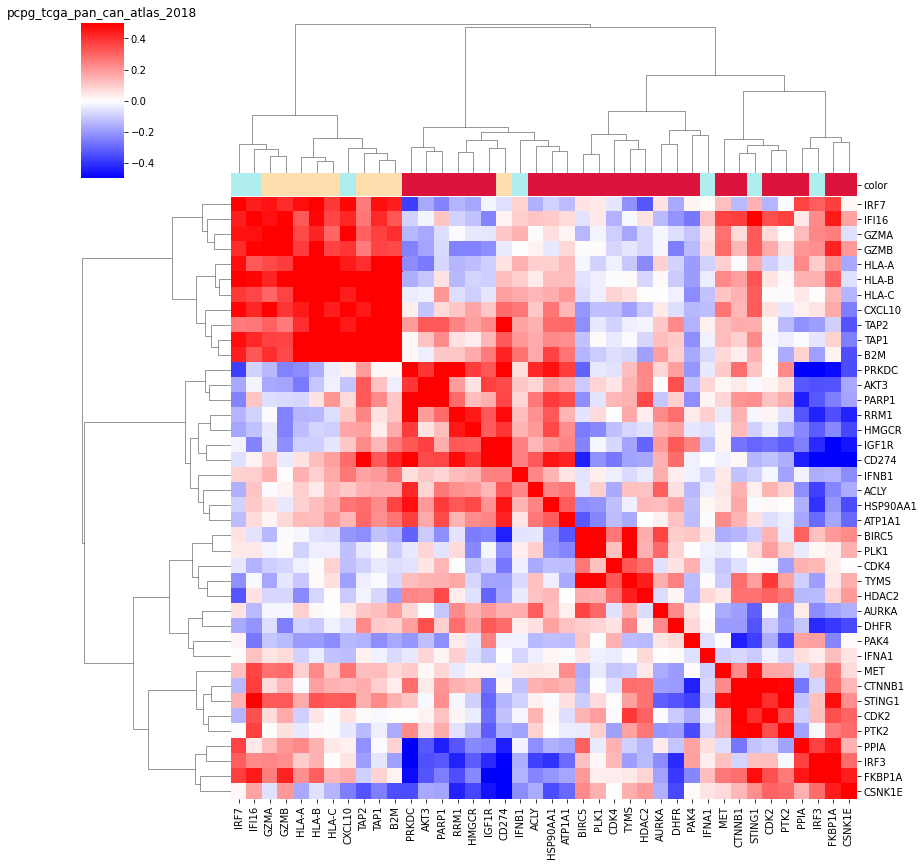

CDK2       -0.161958
RRM1        0.040113
BIRC5       0.112607
PPIA        0.180281
HMGCR      -0.047064
HSP90AA1   -0.123534
PAK4        1.000000
FKBP1A     -0.235208
IGF1R       0.244449
AURKA       0.054033
CDK4        0.152713
PLK1        0.002735
DHFR        0.075485
TYMS       -0.131205
ACLY       -0.138803
PRKDC      -0.206463
AKT3       -0.121859
HDAC2      -0.134664
PARP1      -0.221275
ATP1A1     -0.132492
PTK2       -0.352126
MET        -0.005644
CSNK1E      0.008502
CTNNB1     -0.435421
TAP1       -0.219635
TAP2       -0.151849
B2M        -0.171863
HLA-A      -0.193811
HLA-B      -0.194833
HLA-C      -0.224850
GZMA       -0.111520
GZMB       -0.133520
IFNA1      -0.061493
IFNB1      -0.029128
CXCL10     -0.138671
CD274      -0.028435
IRF3        0.186479
IRF7        0.020771
IFI16      -0.264370
STING1     -0.371184
Name: PAK4, dtype: float64


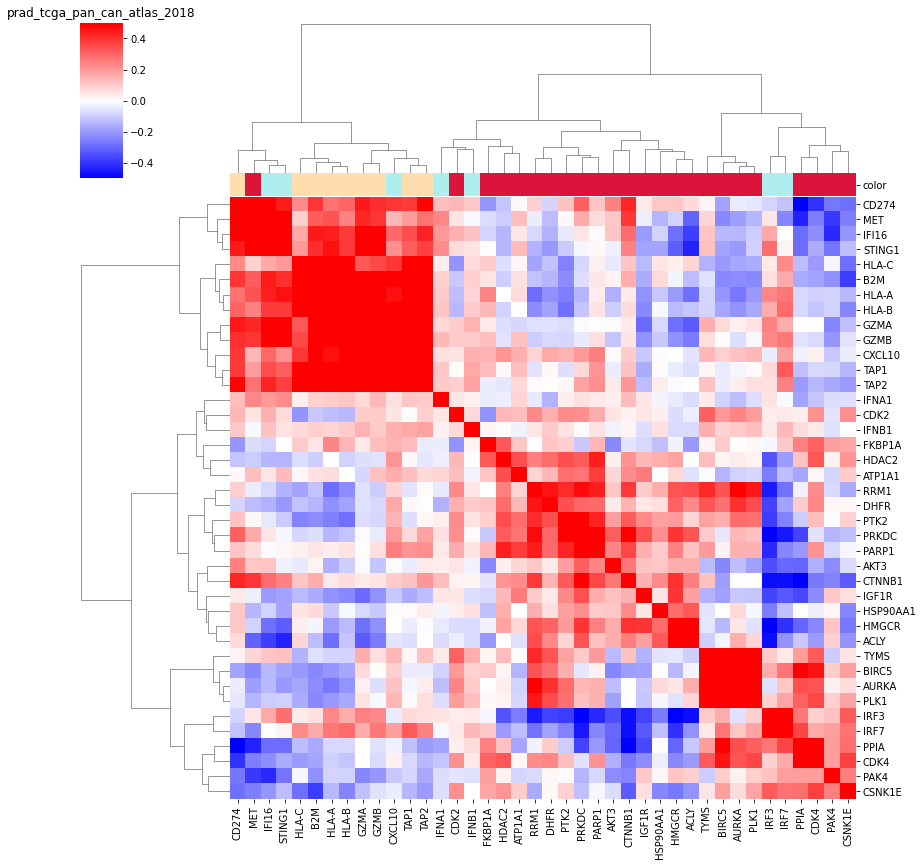

CDK2       -0.053366
RRM1       -0.072641
BIRC5       0.099159
PPIA        0.195143
HMGCR       0.116665
HSP90AA1    0.019502
PAK4        1.000000
FKBP1A      0.183994
IGF1R       0.107532
AURKA       0.030825
CDK4        0.194468
PLK1        0.097304
DHFR        0.016624
TYMS       -0.100427
ACLY        0.097487
PRKDC      -0.141830
AKT3       -0.226033
HDAC2       0.024252
PARP1      -0.077052
ATP1A1     -0.082489
PTK2       -0.010385
MET        -0.388525
CSNK1E      0.253379
CTNNB1     -0.240413
TAP1       -0.079002
TAP2       -0.170650
B2M        -0.217676
HLA-A      -0.083001
HLA-B      -0.087555
HLA-C      -0.016327
GZMA       -0.237598
GZMB       -0.205064
IFNA1      -0.068301
IFNB1      -0.061182
CXCL10     -0.107793
CD274      -0.268297
IRF3        0.123880
IRF7        0.188989
IFI16      -0.419712
STING1     -0.271632
Name: PAK4, dtype: float64


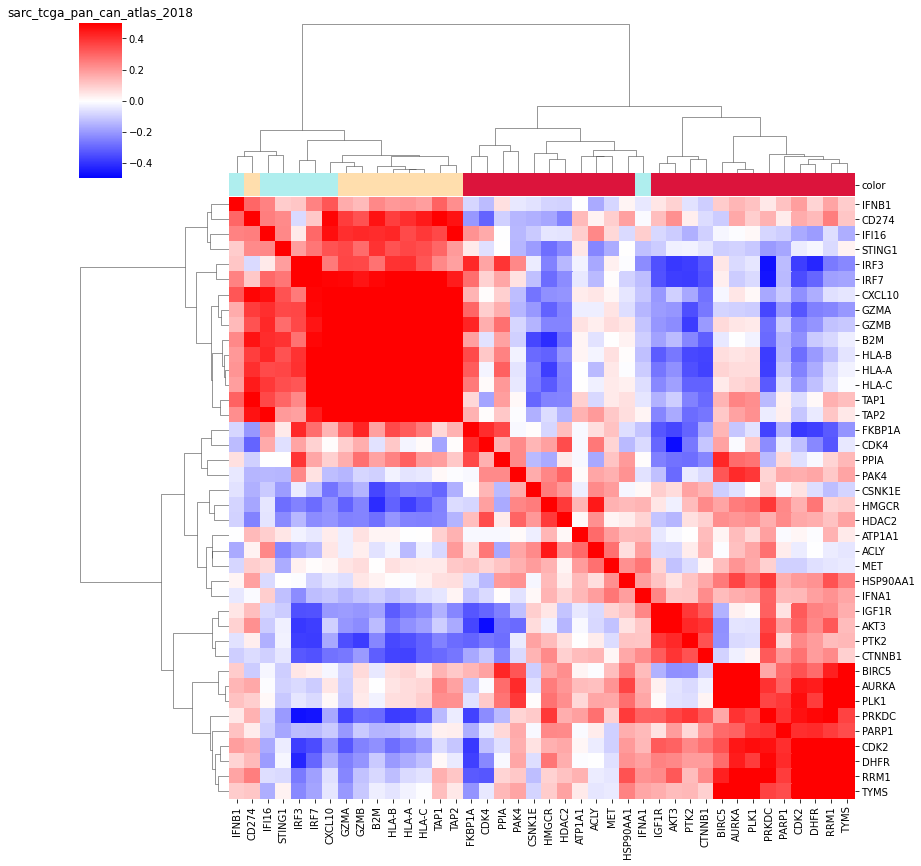

CDK2        0.157133
RRM1        0.106341
BIRC5       0.329487
PPIA        0.230323
HMGCR       0.235552
HSP90AA1    0.212010
PAK4        1.000000
FKBP1A     -0.015116
IGF1R      -0.124897
AURKA       0.416570
CDK4        0.227165
PLK1        0.389974
DHFR        0.173778
TYMS        0.176390
ACLY        0.175437
PRKDC       0.084891
AKT3       -0.292649
HDAC2       0.302351
PARP1       0.167829
ATP1A1      0.009669
PTK2       -0.041369
MET         0.155130
CSNK1E      0.163331
CTNNB1     -0.070440
TAP1        0.011895
TAP2       -0.007255
B2M        -0.092771
HLA-A      -0.054395
HLA-B      -0.026482
HLA-C      -0.044276
GZMA       -0.142164
GZMB       -0.078503
IFNA1      -0.054985
IFNB1      -0.043242
CXCL10     -0.128845
CD274      -0.143695
IRF3        0.231594
IRF7        0.055191
IFI16      -0.139088
STING1     -0.143409
Name: PAK4, dtype: float64


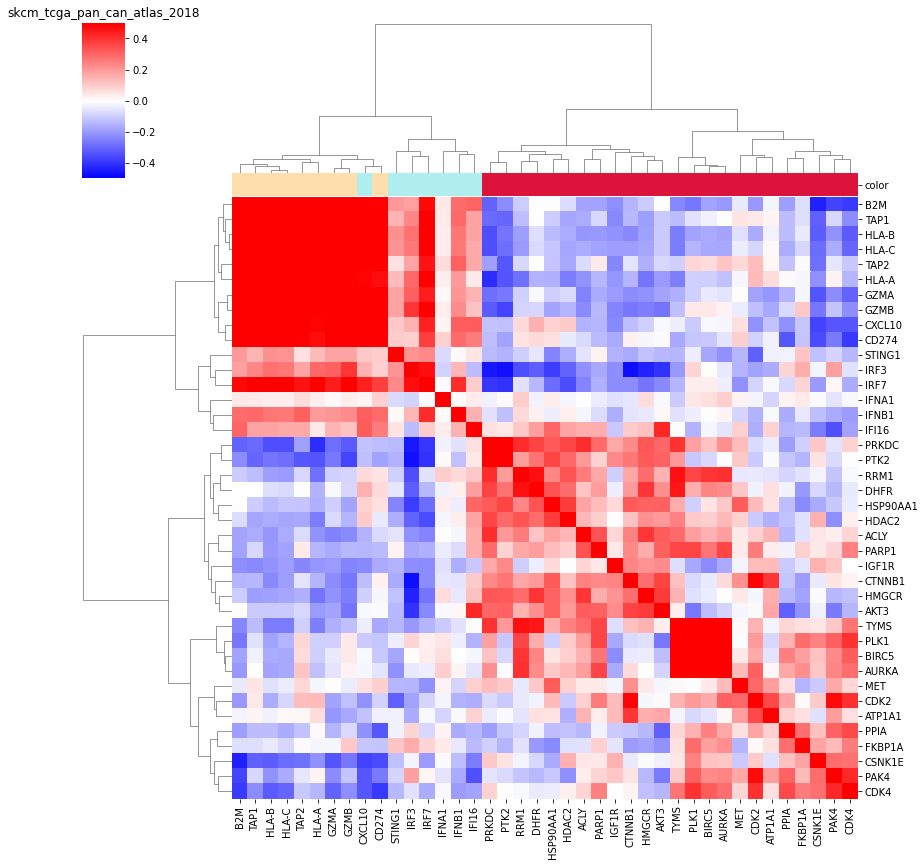

CDK2        0.479190
RRM1       -0.113855
BIRC5       0.229634
PPIA        0.307274
HMGCR      -0.139123
HSP90AA1   -0.107020
PAK4        1.000000
FKBP1A      0.135251
IGF1R       0.112429
AURKA       0.240087
CDK4        0.418137
PLK1        0.310588
DHFR       -0.139889
TYMS        0.108036
ACLY        0.034478
PRKDC      -0.052948
AKT3       -0.260976
HDAC2      -0.221855
PARP1       0.084245
ATP1A1      0.191688
PTK2       -0.073522
MET         0.168782
CSNK1E      0.288791
CTNNB1      0.052689
TAP1       -0.077098
TAP2       -0.049421
B2M        -0.365268
HLA-A       0.026959
HLA-B      -0.214159
HLA-C      -0.162979
GZMA       -0.224029
GZMB       -0.116801
IFNA1      -0.053695
IFNB1      -0.164678
CXCL10     -0.330625
CD274      -0.260438
IRF3        0.184071
IRF7        0.018734
IFI16      -0.343415
STING1     -0.082401
Name: PAK4, dtype: float64


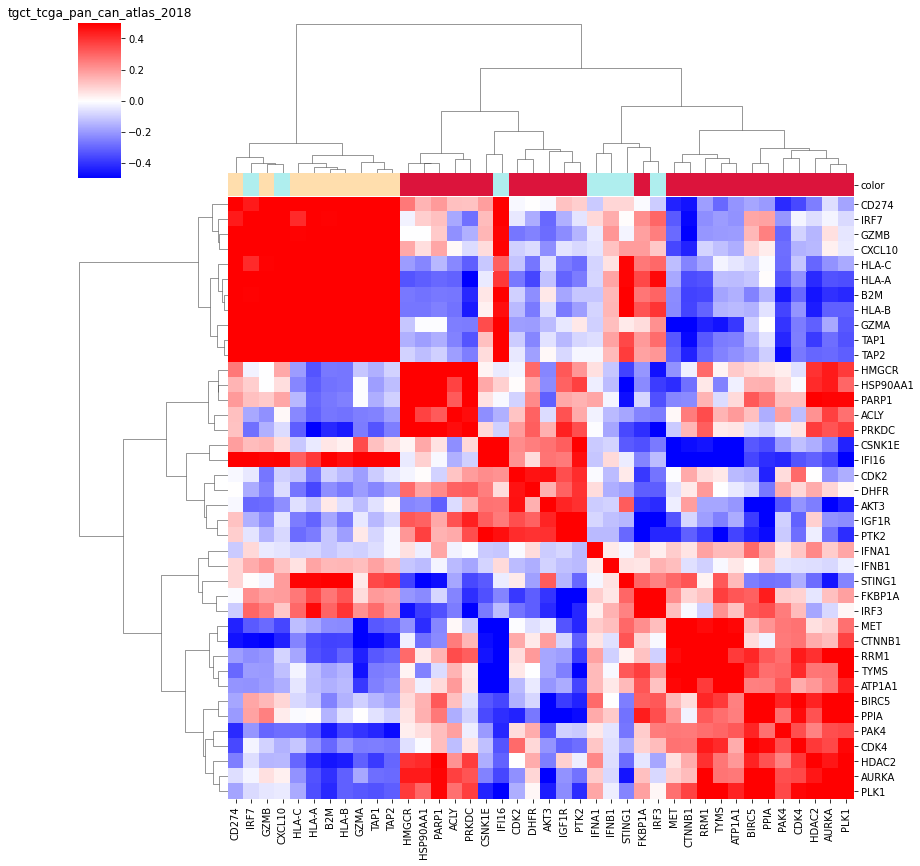

CDK2        0.069663
RRM1        0.284040
BIRC5       0.427570
PPIA        0.279899
HMGCR       0.033049
HSP90AA1    0.064047
PAK4        1.000000
FKBP1A      0.097784
IGF1R      -0.090972
AURKA       0.344163
CDK4        0.344346
PLK1        0.357611
DHFR        0.163138
TYMS        0.300057
ACLY        0.183931
PRKDC      -0.033211
AKT3       -0.331860
HDAC2       0.243269
PARP1       0.128415
ATP1A1      0.327080
PTK2       -0.104288
MET         0.264520
CSNK1E     -0.198114
CTNNB1      0.261063
TAP1       -0.423704
TAP2       -0.478047
B2M        -0.451196
HLA-A      -0.328252
HLA-B      -0.366764
HLA-C      -0.288923
GZMA       -0.396984
GZMB       -0.298769
IFNA1       0.045449
IFNB1      -0.052490
CXCL10     -0.284087
CD274      -0.415244
IRF3        0.254040
IRF7       -0.204332
IFI16      -0.424718
STING1     -0.269481
Name: PAK4, dtype: float64


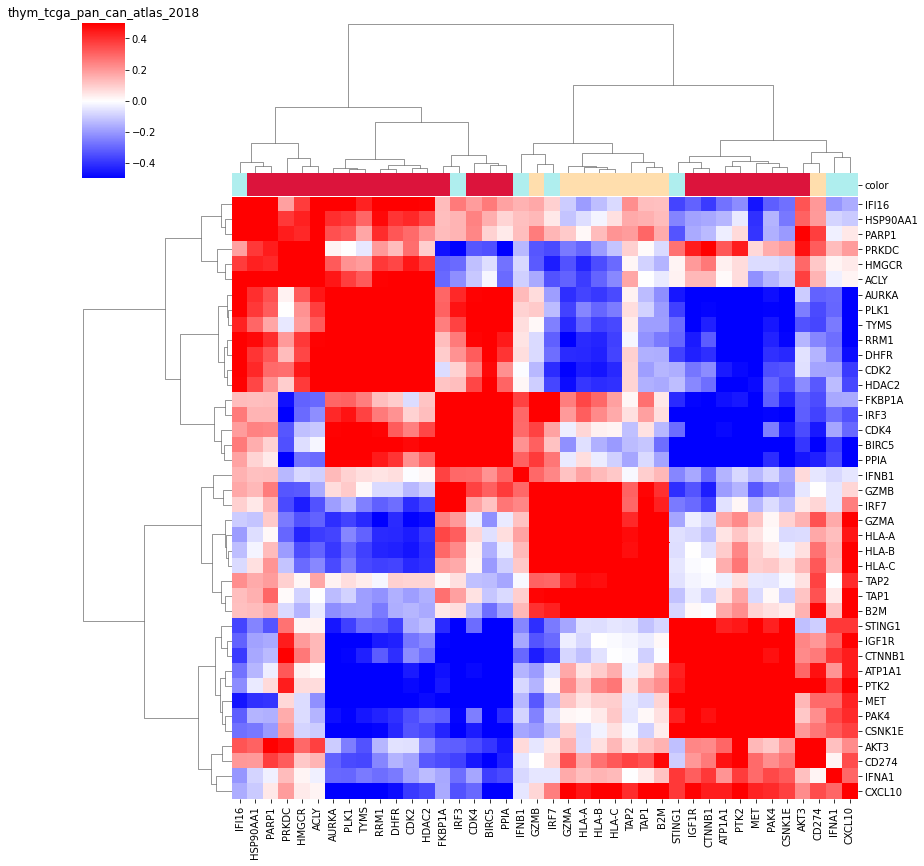

CDK2       -0.343911
RRM1       -0.432787
BIRC5      -0.590550
PPIA       -0.412527
HMGCR      -0.066807
HSP90AA1   -0.147543
PAK4        1.000000
FKBP1A     -0.315254
IGF1R       0.502991
AURKA      -0.470503
CDK4       -0.252008
PLK1       -0.494559
DHFR       -0.405177
TYMS       -0.454544
ACLY       -0.144609
PRKDC       0.163616
AKT3        0.108097
HDAC2      -0.297992
PARP1      -0.154287
ATP1A1      0.522347
PTK2        0.651389
MET         0.556338
CSNK1E      0.679034
CTNNB1      0.468523
TAP1        0.012498
TAP2       -0.047700
B2M         0.059906
HLA-A       0.010796
HLA-B       0.042508
HLA-C       0.108204
GZMA        0.016337
GZMB       -0.244082
IFNA1       0.358383
IFNB1      -0.084485
CXCL10      0.416166
CD274       0.219912
IRF3       -0.489097
IRF7       -0.067576
IFI16      -0.314756
STING1      0.434425
Name: PAK4, dtype: float64


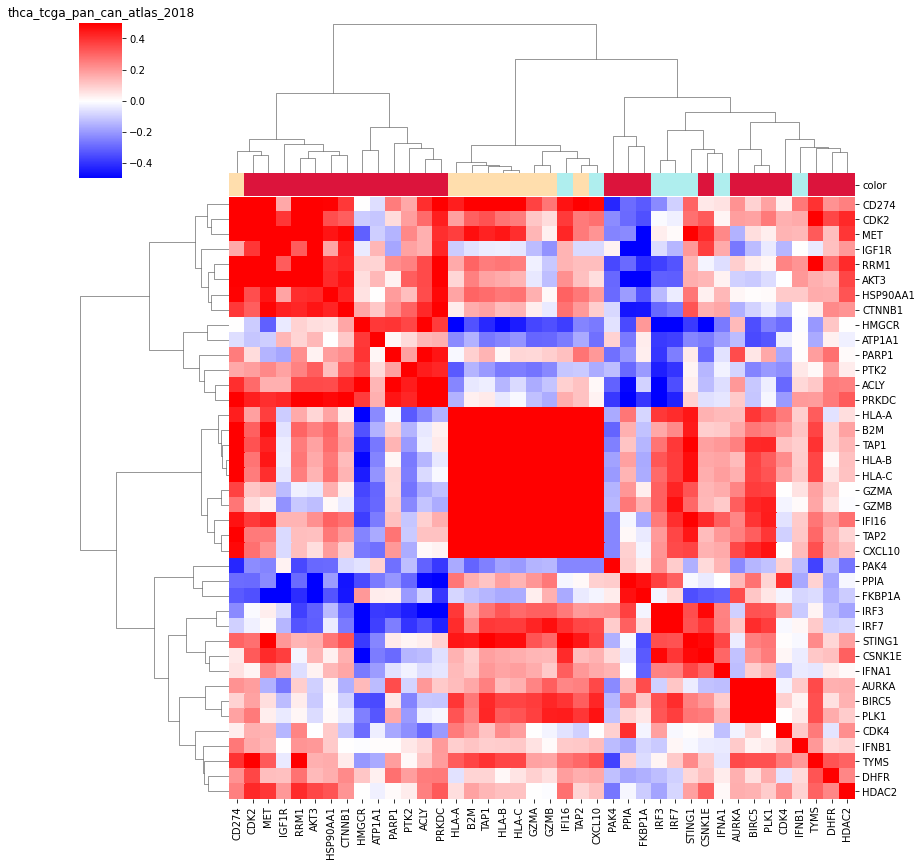

CDK2       -0.222682
RRM1       -0.359117
BIRC5      -0.142869
PPIA        0.099738
HMGCR      -0.056094
HSP90AA1   -0.290834
PAK4        1.000000
FKBP1A      0.038189
IGF1R       0.026557
AURKA      -0.228366
CDK4        0.093067
PLK1       -0.120779
DHFR       -0.124225
TYMS       -0.367463
ACLY       -0.308213
PRKDC      -0.388214
AKT3       -0.293653
HDAC2      -0.265867
PARP1      -0.278331
ATP1A1      0.087225
PTK2       -0.125400
MET        -0.240438
CSNK1E      0.072749
CTNNB1     -0.074653
TAP1       -0.248938
TAP2       -0.237364
B2M        -0.304096
HLA-A      -0.165535
HLA-B      -0.180831
HLA-C      -0.196006
GZMA       -0.148132
GZMB       -0.140266
IFNA1       0.145532
IFNB1      -0.130524
CXCL10     -0.234744
CD274      -0.425341
IRF3        0.218473
IRF7        0.100408
IFI16      -0.234607
STING1     -0.153840
Name: PAK4, dtype: float64


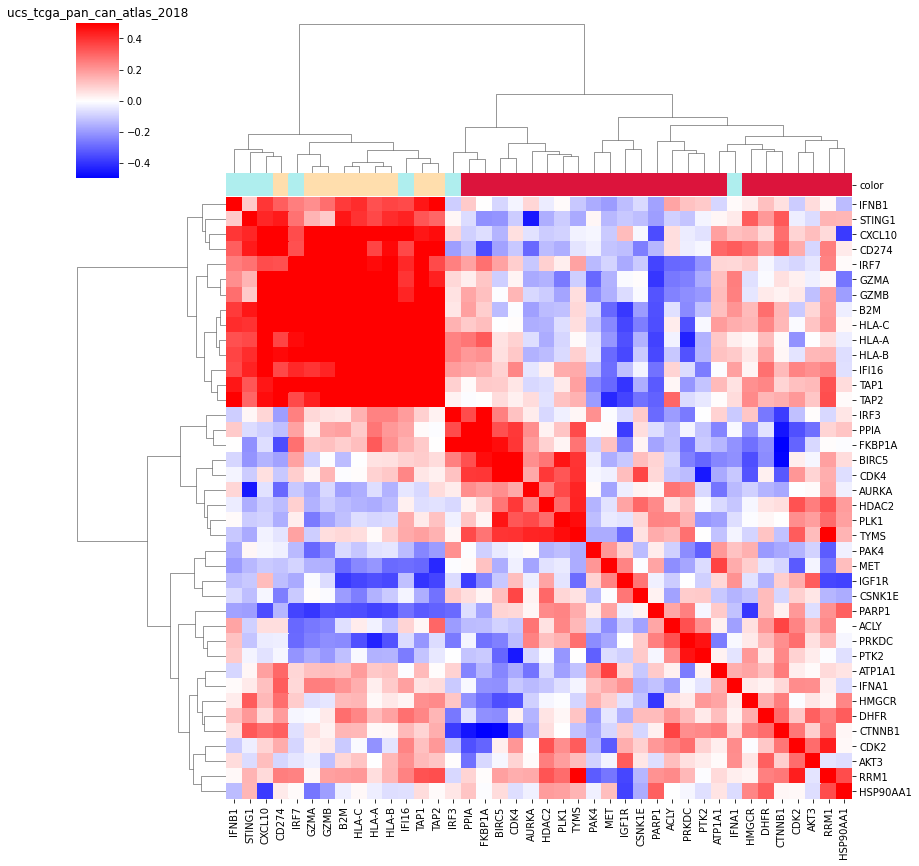

CDK2       -0.146941
RRM1       -0.319743
BIRC5      -0.039085
PPIA       -0.007324
HMGCR       0.153811
HSP90AA1   -0.029168
PAK4        1.000000
FKBP1A     -0.090679
IGF1R       0.086920
AURKA       0.011278
CDK4       -0.019316
PLK1       -0.127431
DHFR       -0.199118
TYMS       -0.161978
ACLY       -0.090550
PRKDC      -0.223101
AKT3       -0.089383
HDAC2      -0.147978
PARP1       0.036946
ATP1A1      0.202878
PTK2       -0.311706
MET         0.204563
CSNK1E     -0.132227
CTNNB1     -0.170599
TAP1       -0.235740
TAP2       -0.193285
B2M        -0.072271
HLA-A      -0.056585
HLA-B      -0.047511
HLA-C      -0.113041
GZMA       -0.294529
GZMB       -0.228221
IFNA1       0.120302
IFNB1      -0.163241
CXCL10     -0.016399
CD274      -0.029205
IRF3        0.215452
IRF7       -0.133848
IFI16      -0.131190
STING1      0.018603
Name: PAK4, dtype: float64


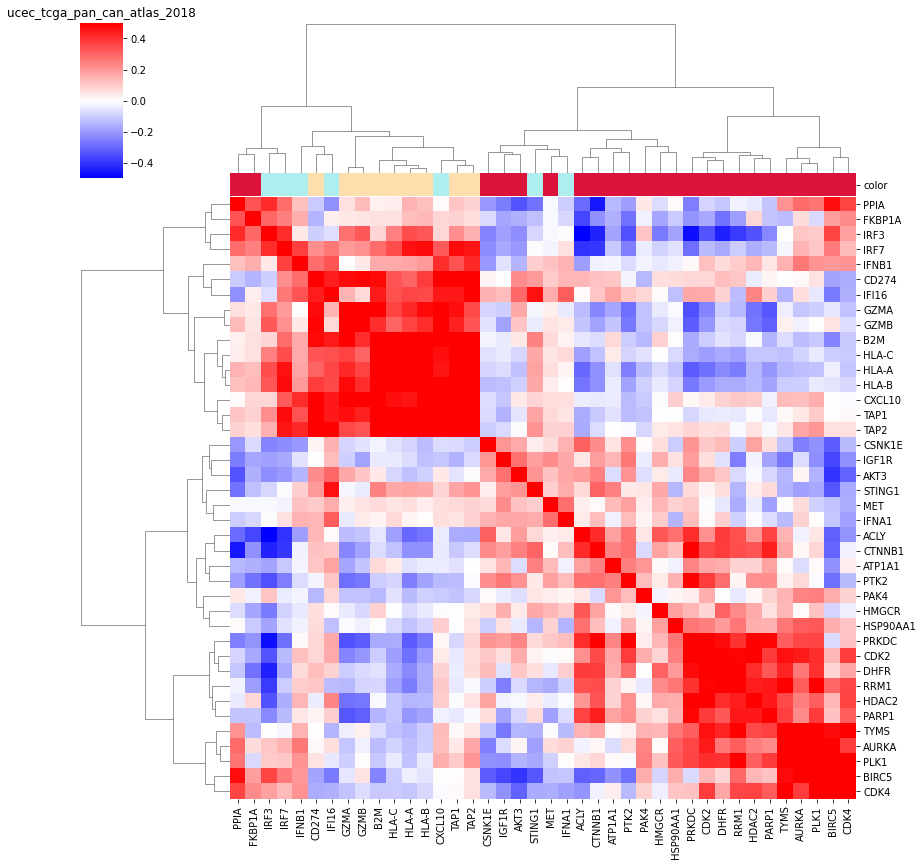

CDK2        0.158250
RRM1       -0.046695
BIRC5       0.160274
PPIA        0.046683
HMGCR      -0.022408
HSP90AA1    0.019682
PAK4        1.000000
FKBP1A     -0.030971
IGF1R      -0.036833
AURKA       0.239071
CDK4        0.088045
PLK1        0.252854
DHFR        0.007811
TYMS        0.147271
ACLY        0.048197
PRKDC       0.036284
AKT3       -0.064808
HDAC2       0.018060
PARP1       0.089665
ATP1A1      0.204975
PTK2        0.132744
MET         0.037278
CSNK1E      0.008967
CTNNB1     -0.072280
TAP1       -0.118488
TAP2       -0.080934
B2M        -0.139057
HLA-A      -0.134696
HLA-B      -0.091324
HLA-C      -0.058394
GZMA       -0.120977
GZMB       -0.119271
IFNA1       0.020734
IFNB1      -0.023372
CXCL10     -0.104992
CD274      -0.136906
IRF3        0.114274
IRF7       -0.035280
IFI16       0.079212
STING1      0.048064
Name: PAK4, dtype: float64


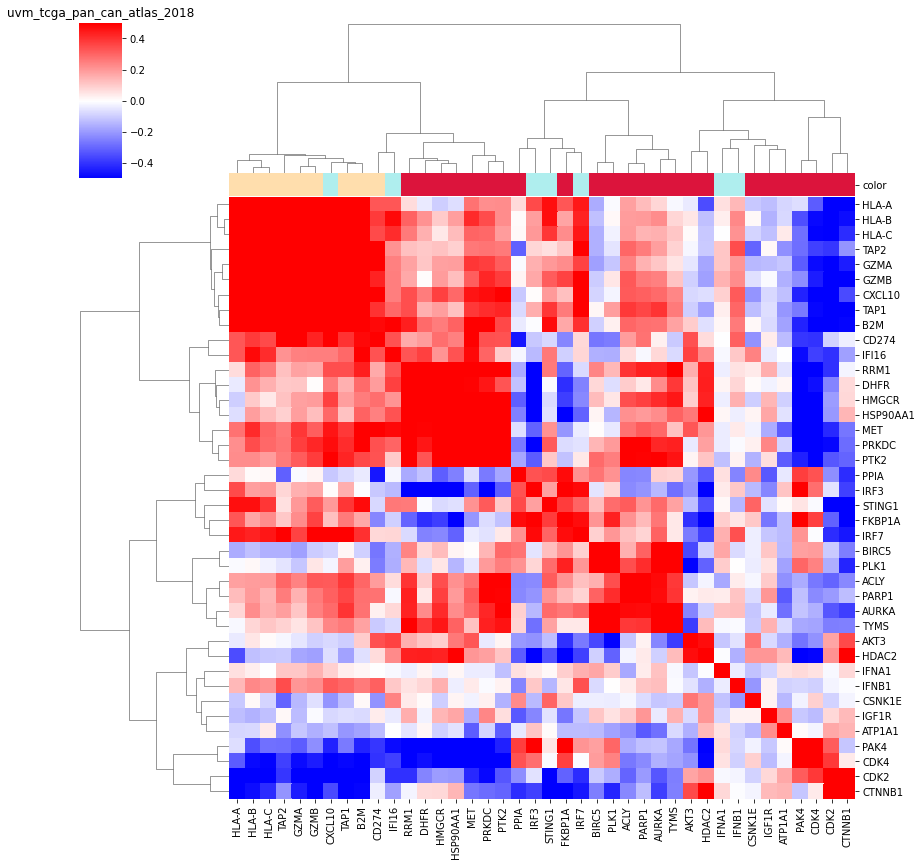

CDK2        0.318167
RRM1       -0.636029
BIRC5       0.186662
PPIA        0.376910
HMGCR      -0.726254
HSP90AA1   -0.833544
PAK4        1.000000
FKBP1A      0.514862
IGF1R      -0.107829
AURKA      -0.114604
CDK4        0.738889
PLK1        0.297234
DHFR       -0.681950
TYMS       -0.168120
ACLY       -0.162611
PRKDC      -0.599086
AKT3       -0.272339
HDAC2      -0.496484
PARP1      -0.121964
ATP1A1      0.008837
PTK2       -0.434271
MET        -0.564674
CSNK1E     -0.023676
CTNNB1     -0.110877
TAP1       -0.257993
TAP2       -0.281880
B2M        -0.432443
HLA-A      -0.064041
HLA-B      -0.344351
HLA-C      -0.278317
GZMA       -0.319106
GZMB       -0.222204
IFNA1       0.070646
IFNB1      -0.079067
CXCL10     -0.430679
CD274      -0.393601
IRF3        0.586943
IRF7        0.208931
IFI16      -0.477637
STING1      0.052368
Name: PAK4, dtype: float64


In [106]:
# correlation between genes for each cancer type
for ct in expr_cbio['STUDY_ID'].unique():
    tmp_ct = expr_cbio[expr_cbio['STUDY_ID'] == ct]
    tmp_ct = tmp_ct.drop('STUDY_ID', axis=1)
    sns.clustermap(tmp_ct.corr(method='spearman'),
                   vmin=-.5, vmax=.5, cmap='bwr',
                   figsize=(12, 12), method='ward',
                   col_colors=expr_cbio_palette['color'])
    plt.title(ct)
    plt.show()
    print(tmp_ct.corr(method='spearman')['PAK4'])